Comparative Study with paper called "Abusive Content Detection in Arabic Tweets Using Multi-Task Learning and Transformer-Based Models" , 2023

### Environment Setting

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat Apr 19 14:54:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |            

In [2]:
import torch

if torch.cuda.is_available():
    # Get the GPU memory details
    total_memory = torch.cuda.get_device_properties(0).total_memory
    reserved_memory = torch.cuda.memory_reserved(0)
    allocated_memory = torch.cuda.memory_allocated(0)
    free_memory = reserved_memory - allocated_memory

    print("Total GPU memory: " ,total_memory )
    print("Memory allocated by PyTorch but not used:",reserved_memory)
    print("Memory actively being used: ", allocated_memory)
    print("Available memory left for use:",free_memory)
else:
    print("No GPU available.")


Total GPU memory:  15828320256
Memory allocated by PyTorch but not used: 0
Memory actively being used:  0
Available memory left for use: 0


In [3]:
from psutil import virtual_memory
# to check the available memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
#!pip install --upgrade accelerate
#!pip install --upgrade accelerate transformers torch
!pip install pytorch-lightning
!pip install transformers
!pip install farasapy
!pip install PyArabic
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 64.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [5]:
# Import Basics
import pandas as pd

import numpy as np
import random
from tqdm.auto import tqdm
import pickle
import re
import os
import sys

from dataclasses import dataclass, field
from typing import Optional
import datasets
from datasets import ClassLabel, load_dataset, Dataset, DatasetDict
import string
from typing import Dict ,List

In [6]:
# Import for models
import torch
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig,EarlyStoppingCallback

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch.nn as nn


import logging

In [7]:
# Visualisation
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
tqdm.pandas()

### Configuration

In [8]:
#'aubmindlab/bert-base-arabertv02'
#'xlm-roberta-base'
#'asafaya/bert-base-arabic'
#'CAMeL-Lab/bert-base-arabic-camelbert-msa'
#selectedModel = 'aubmindlab/bert-base-arabertv02' #The base of all my expierments
selectedModel = 'UBC-NLP/MARBERT'

In [9]:
# Set up logging for Jupyter
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create handler for Jupyter to ensure logs are displayed
if logger.hasHandlers():
    logger.handlers.clear()

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

# Hugging Face-specific logging
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.INFO)

In [10]:
Ex_name = 'Lubna_MTL_Base_'

In [11]:
'''
config = {
    'BATCH_SIZE'         : 8,
    'EPOCHS'             : 5,
    'LR'                 : 0.01,
    'MOMENTUM'           : 0,
    'SEED'               : 42,
    'WANDB'              : True,
}
'''

"\nconfig = {\n    'BATCH_SIZE'         : 8,\n    'EPOCHS'             : 5,\n    'LR'                 : 0.01,\n    'MOMENTUM'           : 0,\n    'SEED'               : 42,\n    'WANDB'              : True,\n}\n"

# Prepare the DataSet

## Load the Data

In [12]:

train_data='/content/All_ArMPro_binary_train.jsonl'
train_df = pd.read_json(train_data)

# Display the DataFrame
train_df.head()

,Unnamed: 0,paragraph_id,paragraph,label,LablePropaganda,LabelSentiment,LabelEmotion
0,0,PEMYqJCxhKkhaenb2jGFFU_001,ندوة «من سلب اسكندرون إلى سلب فلسطين» على مدرج...,True,true,neutral,none
1,1,MIS_2214-eurl_04_016,بعد استقلال الجزائر، تزوجت جميلة بوحيرد بالمحا...,True,true,positive,happiness
2,2,MIS_855-eurl_01_002,وفي الوقت الذي لم تفصح فيه الخاطر عن فحوى ما ح...,True,true,neutral,none
3,3,AFP_336-eurl_01_015,"وبدورها، كتبت نور الهجري، على فيسبوك "" احتفال ...",True,true,positive,happiness
4,4,AFP_161-eurl_01_013,وظل بوتفليقة في سدة الرئاسة الجزائرية نحو 20 ع...,True,true,negative,none


In [13]:


# Reading the JSONL file line by line
dev_data = '/content/All_ArMPro_binary_dev.jsonl'

dev_df = pd.read_json(dev_data)

# Display the DataFrame
dev_df.head()

,Unnamed: 0,paragraph_id,paragraph,label,LablePropaganda,LabelSentiment,LabelEmotion
0,0,MIS_1062-eurl_04_008,وقالت الحكومة السودانية الثلاثاء إنها رفضت مقت...,False,false,negative,sadness
1,1,c5kikhveqPRvXDK89HE8go_004,وأكد الأستاذ نصر باغريب، أن إنشاء مركز التدريب...,True,true,positive,happiness
2,2,MIS_1049-curl_05_006,وتلعب العوامل الإقليمية والعرقية والاجتماعية و...,False,false,neutral,none
3,3,MIS_688-curl_03_012,وسيتابع موقع الصحراوي هذا الموضوع عن كثب خلال ...,True,true,neutral,none
4,4,MIS_2200-eurl_04_008,المحاور: الولايات المتحدة الأميركية حذرت رعايا...,False,false,negative,fear


In [14]:


# Reading the JSONL file line by line
test_data = '/content/All_ArMPro_binary_test.jsonl'

test_df = pd.read_json(test_data)

# Display the DataFrame
test_df.head()

,Unnamed: 0,paragraph_id,paragraph,label,LablePropaganda,LabelSentiment,LabelEmotion
0,0,fEavdmiweHdA8Vu7UfvZw2_011,فيما أشار الدكتور أحمد خليفة، الرئيس التنفيذي ...,False,false,neutral,none
1,1,NU3oAkQa2nrMWG8VKvPe9r_010,"وقال ""لديه الموهبة والجودة، الأمر لا يتعلق بتس...",True,true,positive,happiness
2,2,Uqd2Xgwmgqbi4ZLGaBUMTZ_006,الرعاية الصحية والنفسية للأطفال هي من بين الاو...,True,true,positive,happiness
3,3,MIS_855-eurl_01_005,- جرى تداول معلومات مؤخرا عن رغبة دول الحصار ب...,True,true,positive,happiness
4,4,MIS_403-curl_02_002,وجاء إعلان السلطات السورية لينفي معلومات نشرها...,False,false,neutral,none


In [15]:
train_dev_df = pd.concat([train_df, dev_df], ignore_index=True)
train_dev_test_df = pd.concat([train_dev_df, test_df], ignore_index=True)

In [16]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)
print(train_dev_df.shape)
print(train_dev_test_df.shape)

(6002, 7)
(672, 7)
(1326, 7)
(6674, 7)
(8000, 7)


In [17]:
train_df.columns

Index(['Unnamed: 0', 'paragraph_id', 'paragraph', 'label', 'LablePropaganda',
       'LabelSentiment', 'LabelEmotion'],
      dtype='object')

In [18]:
 # Prepare dataframe
train_df = train_df[['paragraph','LablePropaganda','LabelSentiment','LabelEmotion']]
dev_df = dev_df[['paragraph','LablePropaganda','LabelSentiment','LabelEmotion']]
test_df = test_df[['paragraph','LablePropaganda','LabelSentiment','LabelEmotion']]
train_df.head()

,paragraph,LablePropaganda,LabelSentiment,LabelEmotion
0,ندوة «من سلب اسكندرون إلى سلب فلسطين» على مدرج...,true,neutral,none
1,بعد استقلال الجزائر، تزوجت جميلة بوحيرد بالمحا...,true,positive,happiness
2,وفي الوقت الذي لم تفصح فيه الخاطر عن فحوى ما ح...,true,neutral,none
3,"وبدورها، كتبت نور الهجري، على فيسبوك "" احتفال ...",true,positive,happiness
4,وظل بوتفليقة في سدة الرئاسة الجزائرية نحو 20 ع...,true,negative,none


## Label Mapping

In [19]:
# Label mapping
propaganda_mapping = {'false': 0, 'true': 1}
sentiment_mapping = {'neutral': 0, 'positive': 1, 'negative':2}
emotion_mapping = {"none":0,"happiness":1,"sadness": 2,"anger": 3,"fear": 4}


#propaganda

train_df['LablePropaganda'] = train_df['LablePropaganda'].apply(lambda x: propaganda_mapping[x])
dev_df['LablePropaganda'] = dev_df['LablePropaganda'].apply(lambda x: propaganda_mapping[x])
test_df['LablePropaganda'] = test_df['LablePropaganda'].apply(lambda x: propaganda_mapping[x])

#Sentiment
train_df['LabelSentiment'] = train_df['LabelSentiment'].apply(lambda x: sentiment_mapping [x])
dev_df['LabelSentiment'] = dev_df['LabelSentiment'].apply(lambda x: sentiment_mapping [x])
test_df['LabelSentiment'] = test_df['LabelSentiment'].apply(lambda x: sentiment_mapping [x])


#Emotion
train_df['LabelEmotion'] = train_df['LabelEmotion'].apply(lambda x: emotion_mapping [x])
dev_df['LabelEmotion'] = dev_df['LabelEmotion'].apply(lambda x: emotion_mapping[x])
test_df['LabelEmotion'] = test_df['LabelEmotion'].apply(lambda x: emotion_mapping[x])

In [20]:
train_df['LabelSentiment'].dtype

dtype('int64')

In [21]:
train_df['LabelEmotion'].dtype

dtype('int64')

In [22]:
train_df['LablePropaganda'].dtype

dtype('int64')

In [23]:
train_df.head(10)

,paragraph,LablePropaganda,LabelSentiment,LabelEmotion
0,ندوة «من سلب اسكندرون إلى سلب فلسطين» على مدرج...,1,0,0
1,بعد استقلال الجزائر، تزوجت جميلة بوحيرد بالمحا...,1,1,1
2,وفي الوقت الذي لم تفصح فيه الخاطر عن فحوى ما ح...,1,0,0
3,"وبدورها، كتبت نور الهجري، على فيسبوك "" احتفال ...",1,1,1
4,وظل بوتفليقة في سدة الرئاسة الجزائرية نحو 20 ع...,1,2,0
5,واقتصرت زيارة الوفد على العاصمة يانغون واللقاء...,1,2,2
6,أنقذ زوال أول أمس أعوان الحماية المدنية بالعمل...,1,1,1
7,مع بداية عام 2021، استطاع تطبيق التراسل الفوري...,1,1,0
8,وفي 26 تشرين الثاني/نوفمبر أعلنت فلوريدا فوز ج...,1,0,0
9,​​وينتمي مشهد المحاكمة الذي يتحدث عنه بن يوسف ...,0,2,0


In [24]:
propaganda_class_names = ['propaganda','not-propaganda']
sentiment_class_names=['neutral', 'positive', 'negative']
emotion_class_names=["none","happiness","sadness","anger","fear"]

## Data Analysis (training set)

In [25]:
train_df['LablePropaganda'].value_counts()


,count
LablePropaganda,
1,3777
0,2225


In [26]:
dev_df['LablePropaganda'].value_counts()


,count
LablePropaganda,
1,425
0,247


In [27]:
train_df['LabelSentiment'].value_counts()

,count
LabelSentiment,
2,2568
1,2158
0,1276


In [28]:
train_df['LabelEmotion'].value_counts()

,count
LabelEmotion,
1,1818
0,1697
2,1229
3,1001
4,257


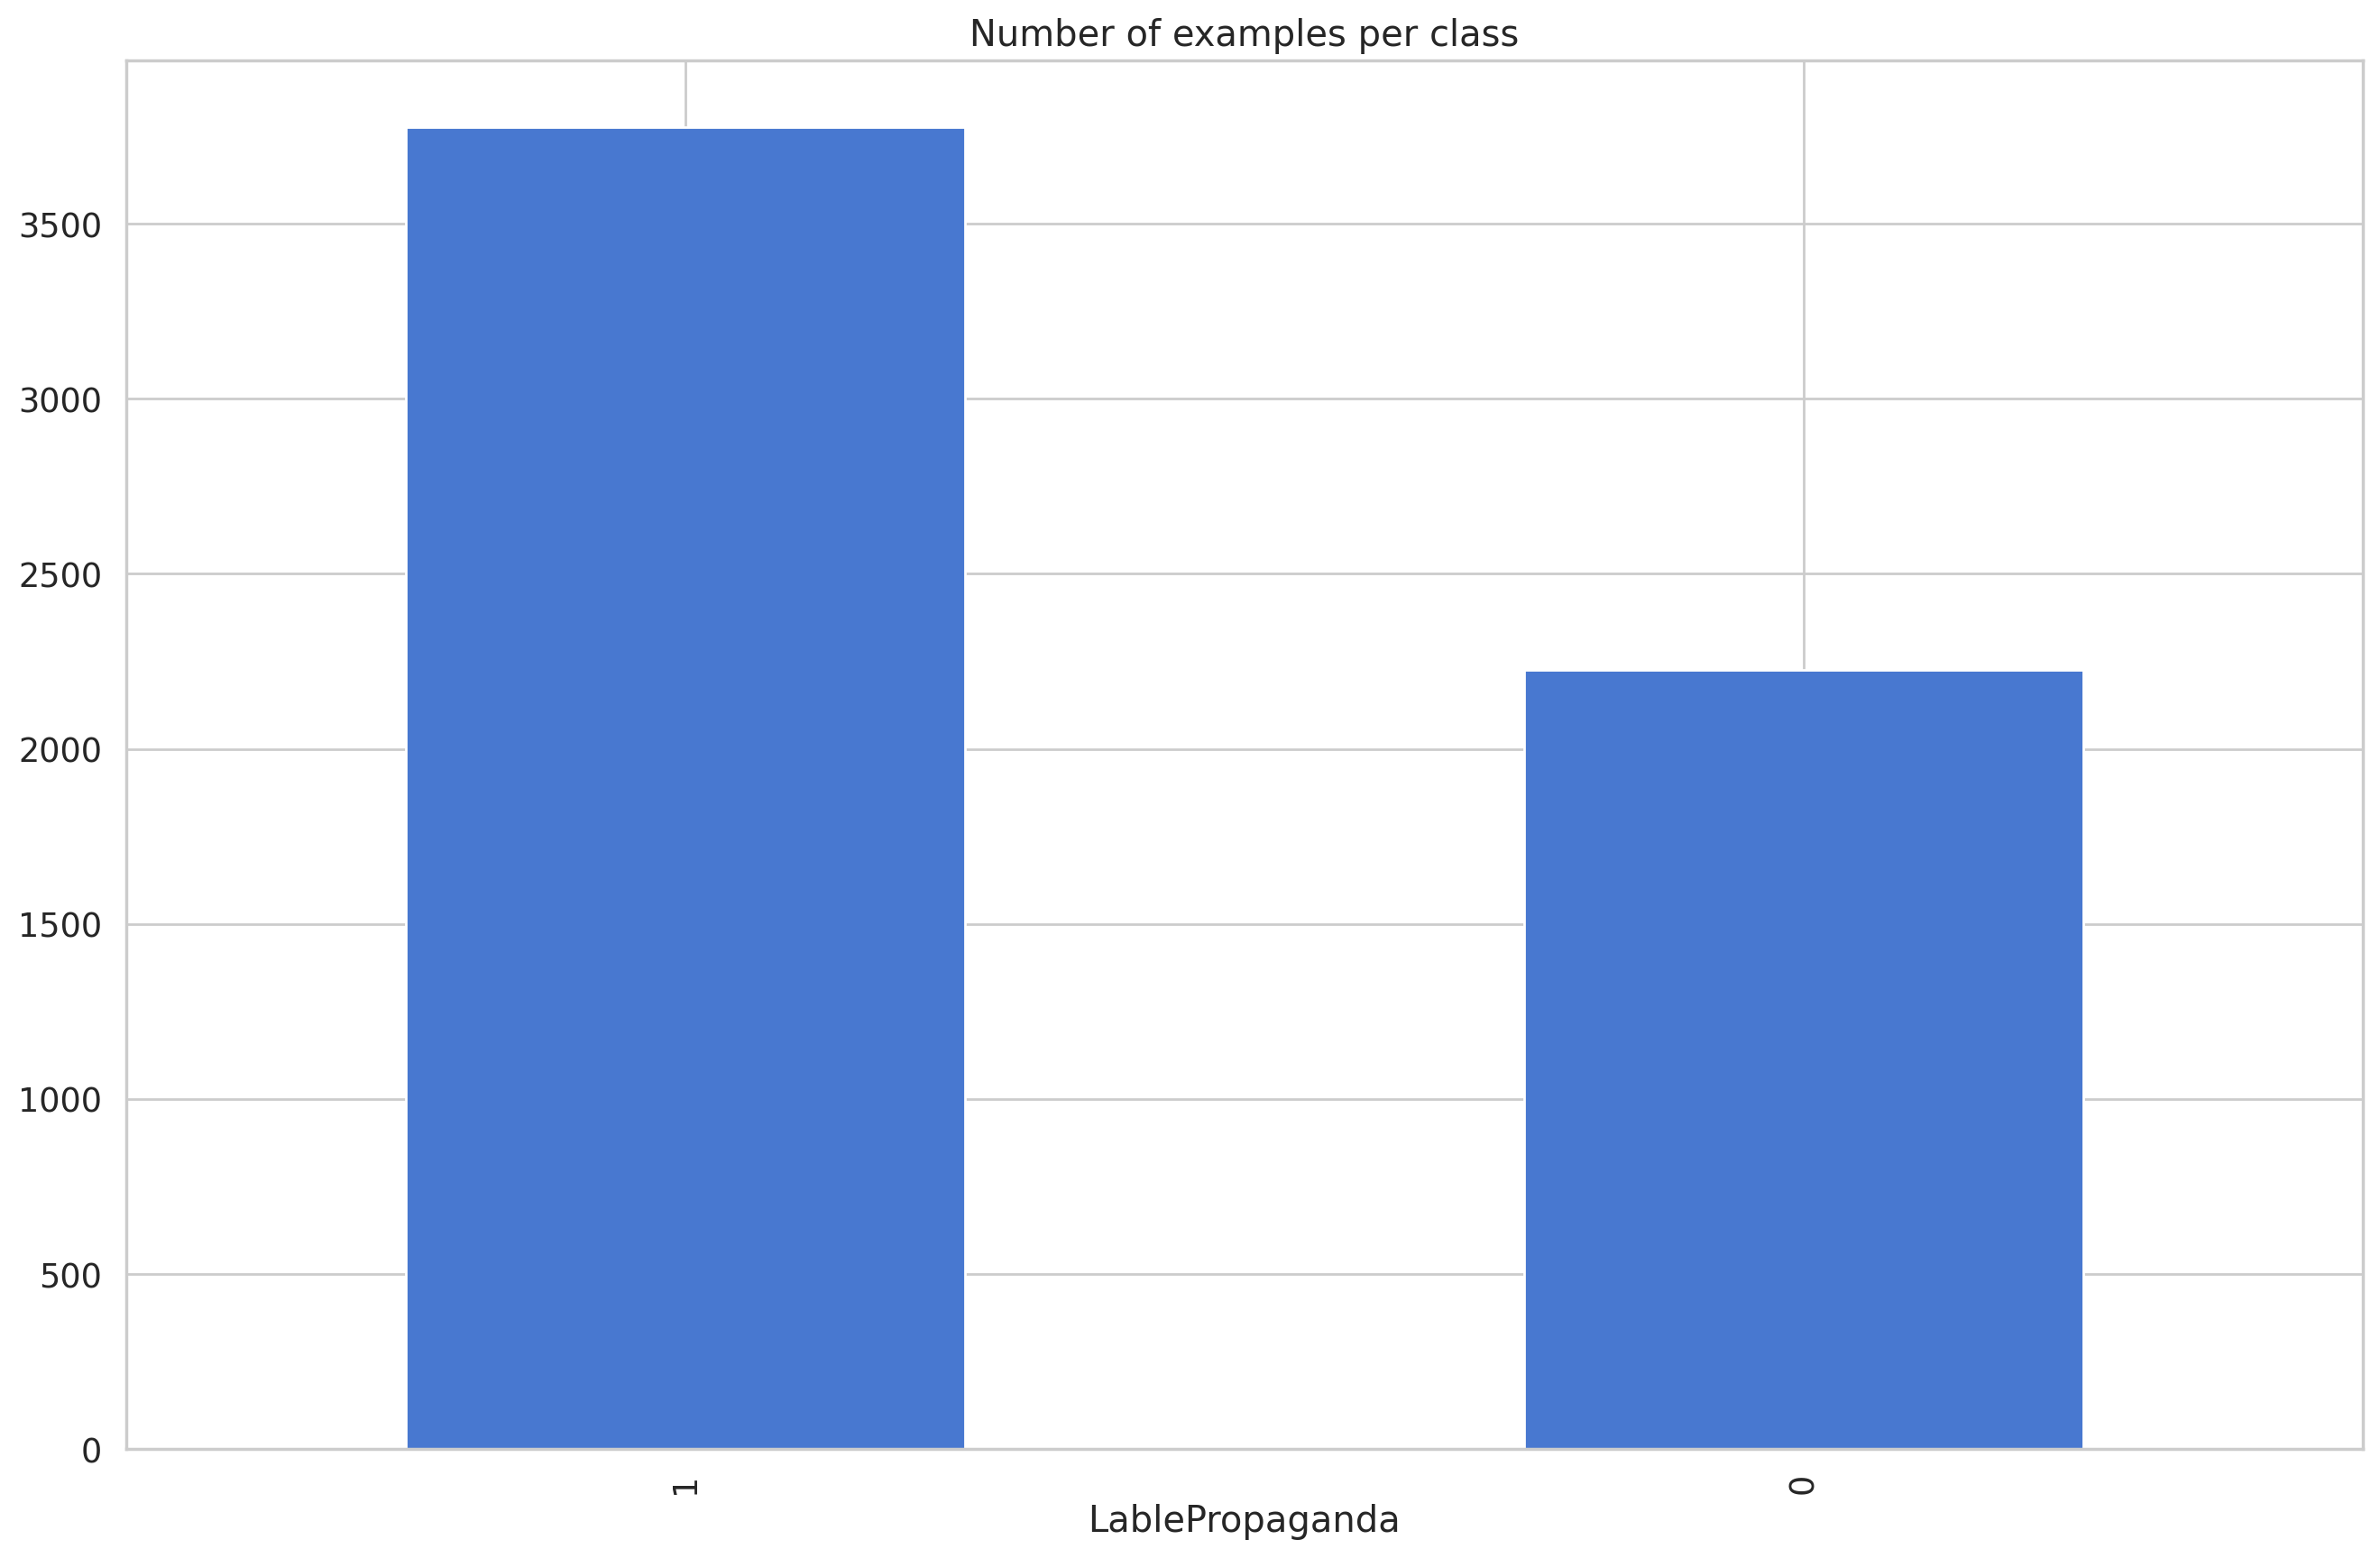

In [29]:
train_df['LablePropaganda'].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Number of examples per class");

## Data Preprocessing

In [30]:
!git clone https://github.com/aub-mind/arabert/

Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535 (from 1)
Receiving objects: 100% (600/600), 9.14 MiB | 37.90 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [31]:
model_name = "bert-base-arabertv02"

In [32]:
from arabert.preprocess import ArabertPreprocessor
import string
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Arabic stop words
stop_words = set(stopwords.words('arabic'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
#https://github.com/aub-mind/arabert/blob/master/preprocess.py
# Default values of parameters:
#ArabertPreprocessor(model_name: str, remove_html_markup: bool=True, replace_urls_emails_mentions: bool=True, strip_tashkeel: bool=True,
#                    strip_tatweel: bool=True, insert_white_spaces: bool=True, remove_non_digit_repetition: bool=True, keep_emojis: bool=None,
#                    replace_slash_with_dash: bool=None, map_hindi_numbers_to_arabic: bool=None, apply_farasa_segmentation: bool=None)

arabert_prep = ArabertPreprocessor(model_name=model_name, remove_html_markup=True, replace_urls_emails_mentions=True, strip_tashkeel=True,strip_tatweel=True,
insert_white_spaces=True, remove_non_digit_repetition=True, keep_emojis=False,
replace_slash_with_dash=True, map_hindi_numbers_to_arabic=True, apply_farasa_segmentation=True)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [04:43<00:00, 851kiB/s]


[2025-04-19 15:12:48,676 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [34]:
def preprocess_arabic_text(text):
    # Step 1: Apply Arabert preprocessing
    text = arabert_prep.preprocess(text)

    # Step 2: Remove non-Arabic text (optional if Arabert already filters this)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Step 3: Character normalization
    text = re.sub(r'\bء', 'ا', text)  # Replace 'ء' at the beginning of words
    text = re.sub(r'[ؤ]', 'و', text)  # Replace 'ؤ' with 'و'
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Step 4: Remove punctuation

    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    text= text.translate(translator)


    # Step 5: Stop word elimination
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    processed_text = ' '.join(filtered_words)

    return processed_text


In [35]:
# check pre-processing by taking sample before applied to all dataset
sample_text = train_df.iloc[41]
sample_text

,41
paragraph,وأدى حسني، واسمه شقرون حسني، الكثير من الأغاني...
LablePropaganda,1
LabelSentiment,1
LabelEmotion,1


In [36]:
sample_text.paragraph

'وأدى حسني، واسمه شقرون حسني، الكثير من الأغاني، إلى أن برز طابعه العاطفي الخاص الذي ألهب مشاعر ملايين الشباب، ليس في الجزائر فحسب بل وفي البلدان المغاربية، وفي فرنسا وعواصم تواجد الجالية المغاربية.'

In [37]:
print(type(sample_text.paragraph))

<class 'str'>


In [38]:
#appplied only arabert preprocessing
preprocessed_text = arabert_prep.preprocess(sample_text.paragraph)
preprocessed_text

'وأدى حسني ، واسمه شقرون حسني ، الكثير من الأغاني ، إلى أن برز طابعه العاطفي الخاص الذي ألهب مشاعر ملايين الشباب ، ليس في الجزائر فحسب بل وفي البلدان المغاربية ، وفي فرنسا وعواصم تواجد الجالية المغاربية .'

In [39]:
sample_preprocessed_text= preprocess_arabic_text(preprocessed_text)
sample_preprocessed_text

'وادي حسني واسمه شقرون حسني الكثير الاغاني الي ان برز طابعه العاطفي الخاص الهب مشاعر ملايين الشباب الجزاءر فحسب وفي البلدان المغاربيه وفي فرنسا وعواصم تواجد الجاليه المغاربيه'

In [40]:
print(type(sample_preprocessed_text))

<class 'str'>


In [41]:
sample_target=sample_text.LablePropaganda
print(sample_target)
print(type(sample_target))

1
<class 'numpy.int64'>


In [42]:
# Apply preprocessing function to all the DataFrame
train_df['paragraph'] = train_df['paragraph'].apply(preprocess_arabic_text)
dev_df['paragraph'] = dev_df['paragraph'].apply(preprocess_arabic_text)
test_df['paragraph'] = test_df['paragraph'].apply(preprocess_arabic_text)

In [43]:
# Sanity check on the dataset after arabert processing
list(train_df['paragraph'][0:12])

['ندوه سلب اسكندرون الي سلب فلسطين علي مدرج دار البعث دمشق بمشاركه القومي العميد عضو المكتب السياسي القومي طارق الاحمد انقاذ بلادنا يكون بفتح الحدود علي محور بيروت دمشق بغداد ضمن اهم حامل نضالي سوريه الطبيعيه',
 'استقلال الجزاءر تزوجت جميله بوحيرد بالمحامي الفرنسي جاك فيرجس عام الي وقد اشهر اسلامه واتخذ اسم منصور ومنحت الجنسيه الجزاءريه وبات يلقب محامي الارض وقد انجبت بوحيرد الابناء مريم والياس',
 'وفي الوقت تفصح الخاطر فحوي حمله وزير الخارجيه الكويتي احمد بن ناصر المحمد الصباح خلال زيارته الاخيره الي قطر اطار الوساطه الكويتيه لحل الازمه الخليجيه جددت الخاطر تمسك دوله قطر بالحوار المشروط باسس وركاءز معينه لحل الازمه الخليجيه اهمها الاحترام المتبادل يحفظ سياده الدول ويضمن عدم التعدي علي استقلاليه القرارات',
 'وبدورها كتبت نور الهجري علي فيسبوك احتفال بعيد الانوار البحرين مستغربا خاصه وان سفيره البحرين السابقه الولايات المتحده كانت هدي نونو يهوديه عربيه تذكير بالتعايش والتسامح',
 'وظل بوتفليقه سده الرءاسه الجزاءريه عاما ولم يظهر بشكل علني عام الا نادرا اصابته بجلطه دماغيه عام',
 'واقتصرت

## Load data into Huggingface

In [44]:
# load the dataset from pandas dataframe to Huggingface Dataset

train = Dataset.from_pandas(train_df)
dev = Dataset.from_pandas(dev_df)
test= Dataset.from_pandas(test_df)

loaded_datasets = DatasetDict()

loaded_datasets['train'] = train
loaded_datasets['validation'] = dev
loaded_datasets['test'] = test

In [45]:
loaded_datasets

DatasetDict({
    train: Dataset({
        features: ['paragraph', 'LablePropaganda', 'LabelSentiment', 'LabelEmotion'],
        num_rows: 6002
    })
    validation: Dataset({
        features: ['paragraph', 'LablePropaganda', 'LabelSentiment', 'LabelEmotion'],
        num_rows: 672
    })
    test: Dataset({
        features: ['paragraph', 'LablePropaganda', 'LabelSentiment', 'LabelEmotion'],
        num_rows: 1326
    })
})

# Building The Multi-Task Dataset

1. Define the tokenizer
2. Build and tokenize the Propaganda_dataset
3. Build and tokenize the Sentiment_dataset
4. Build and tokenize the Emotion_dataset
5. Merge all datasets


## Set Parameters

In [46]:
## Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained(selectedModel) #,add_prefix_space=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  

In [47]:
config = AutoConfig.from_pretrained(selectedModel)

# Print all configuration details
print(config)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [48]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(row.paragraph, max_length=512, truncation=True))
  token_counts.append(token_count)

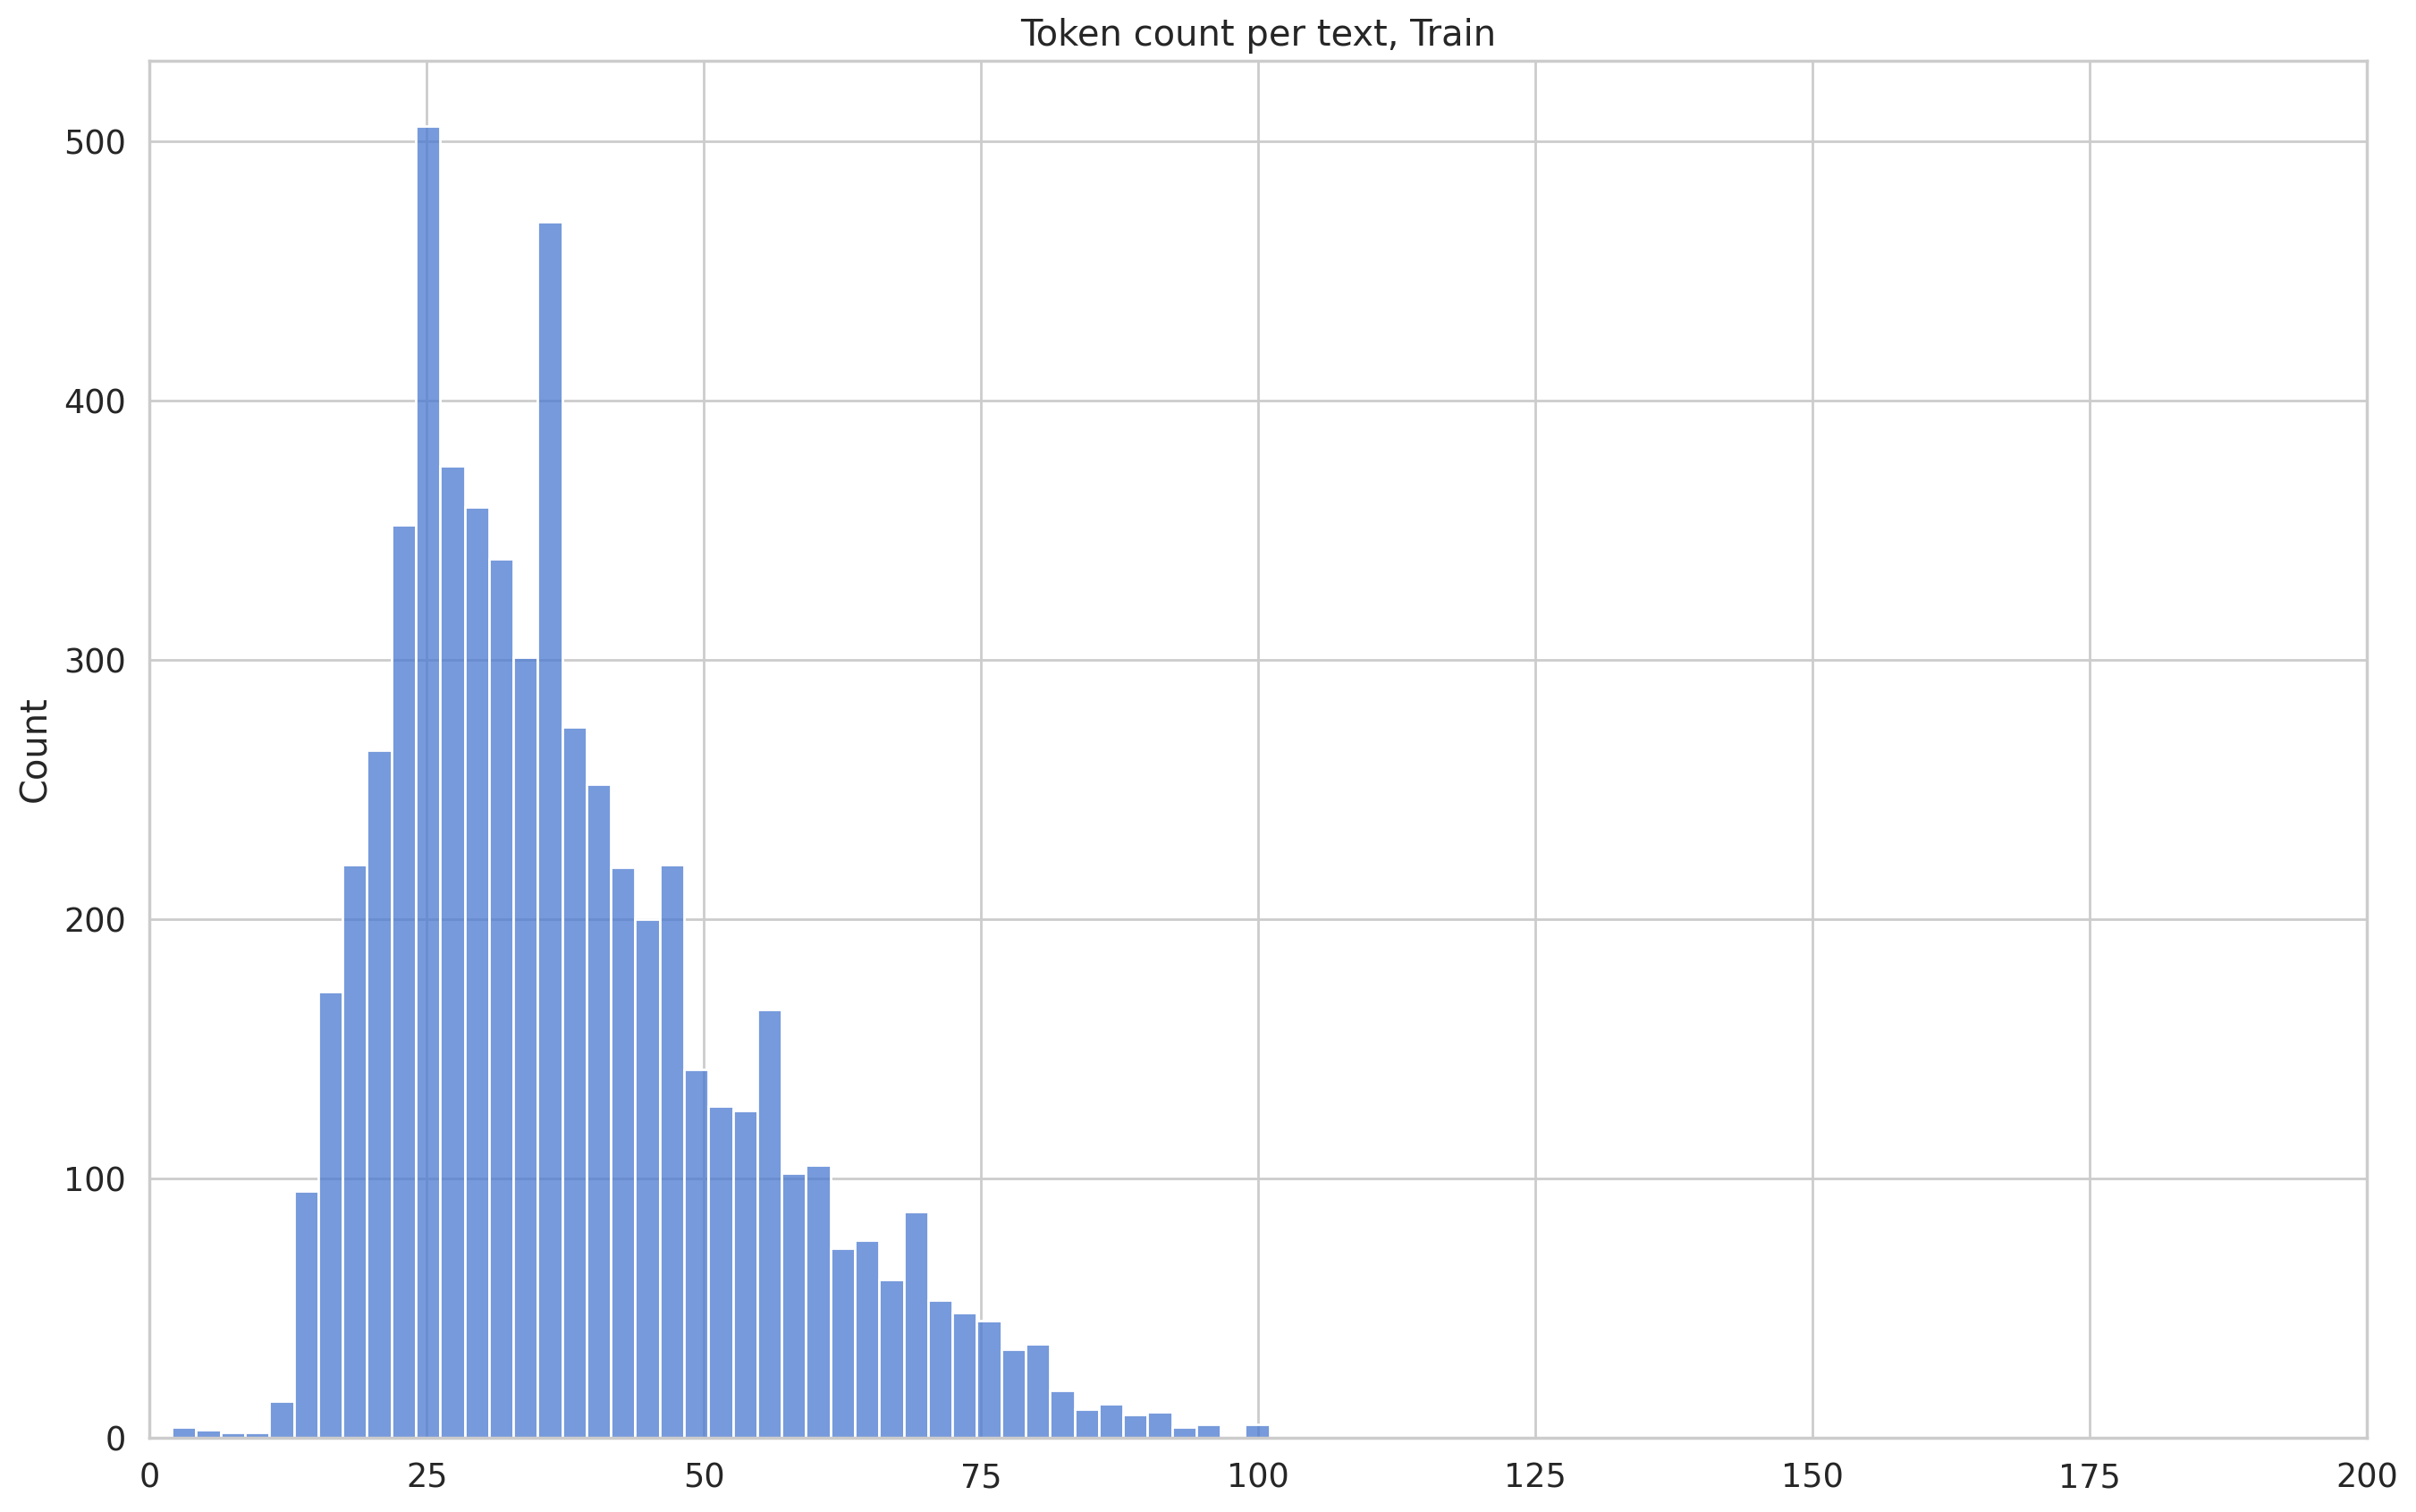

In [49]:
sns.histplot(token_counts)
plt.xlim([0, 200]);
plt.title("Token count per text, Train");

In [50]:
max(token_counts), min(token_counts), sum(token_counts) / len(token_counts)

(101, 2, 37.770576474508495)

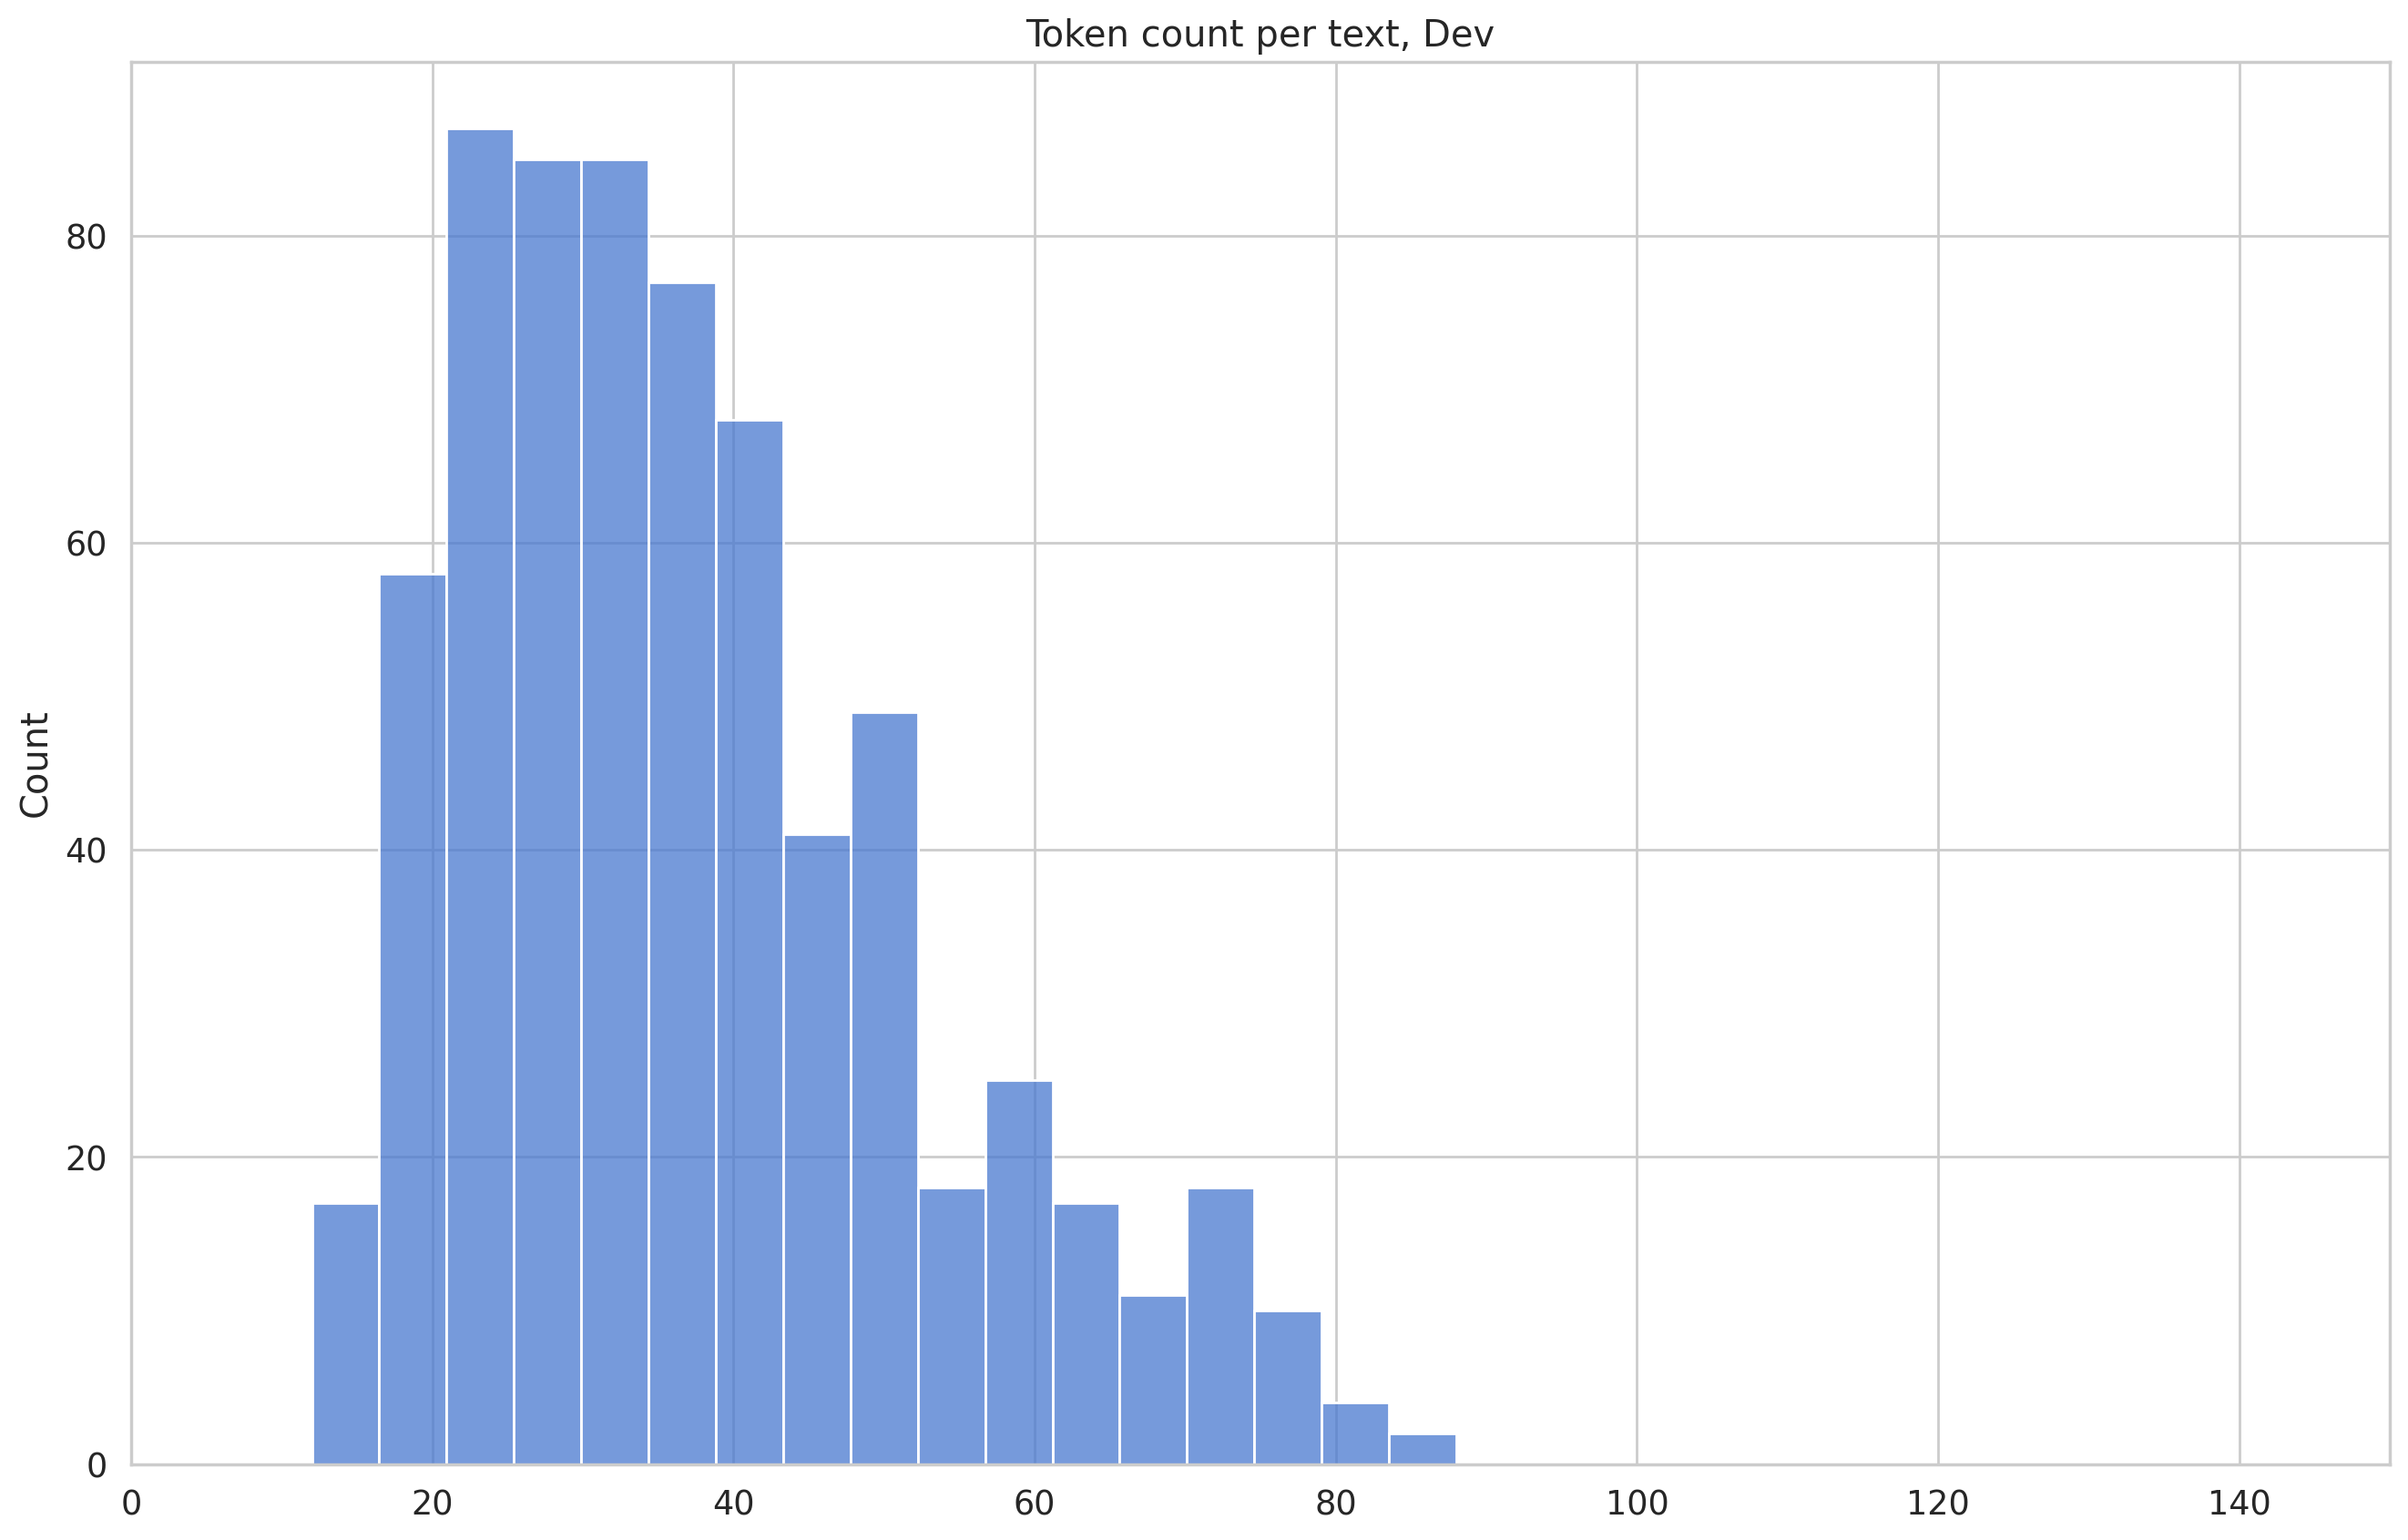

In [51]:
token_counts = []
for _, row in dev_df.iterrows():
  token_count = len(tokenizer.encode(
    row["paragraph"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 150]);
plt.title("Token count per text, Dev");

In [52]:
max(token_counts), min(token_counts), sum(token_counts) / len(token_counts)


(88, 12, 37.45386904761905)

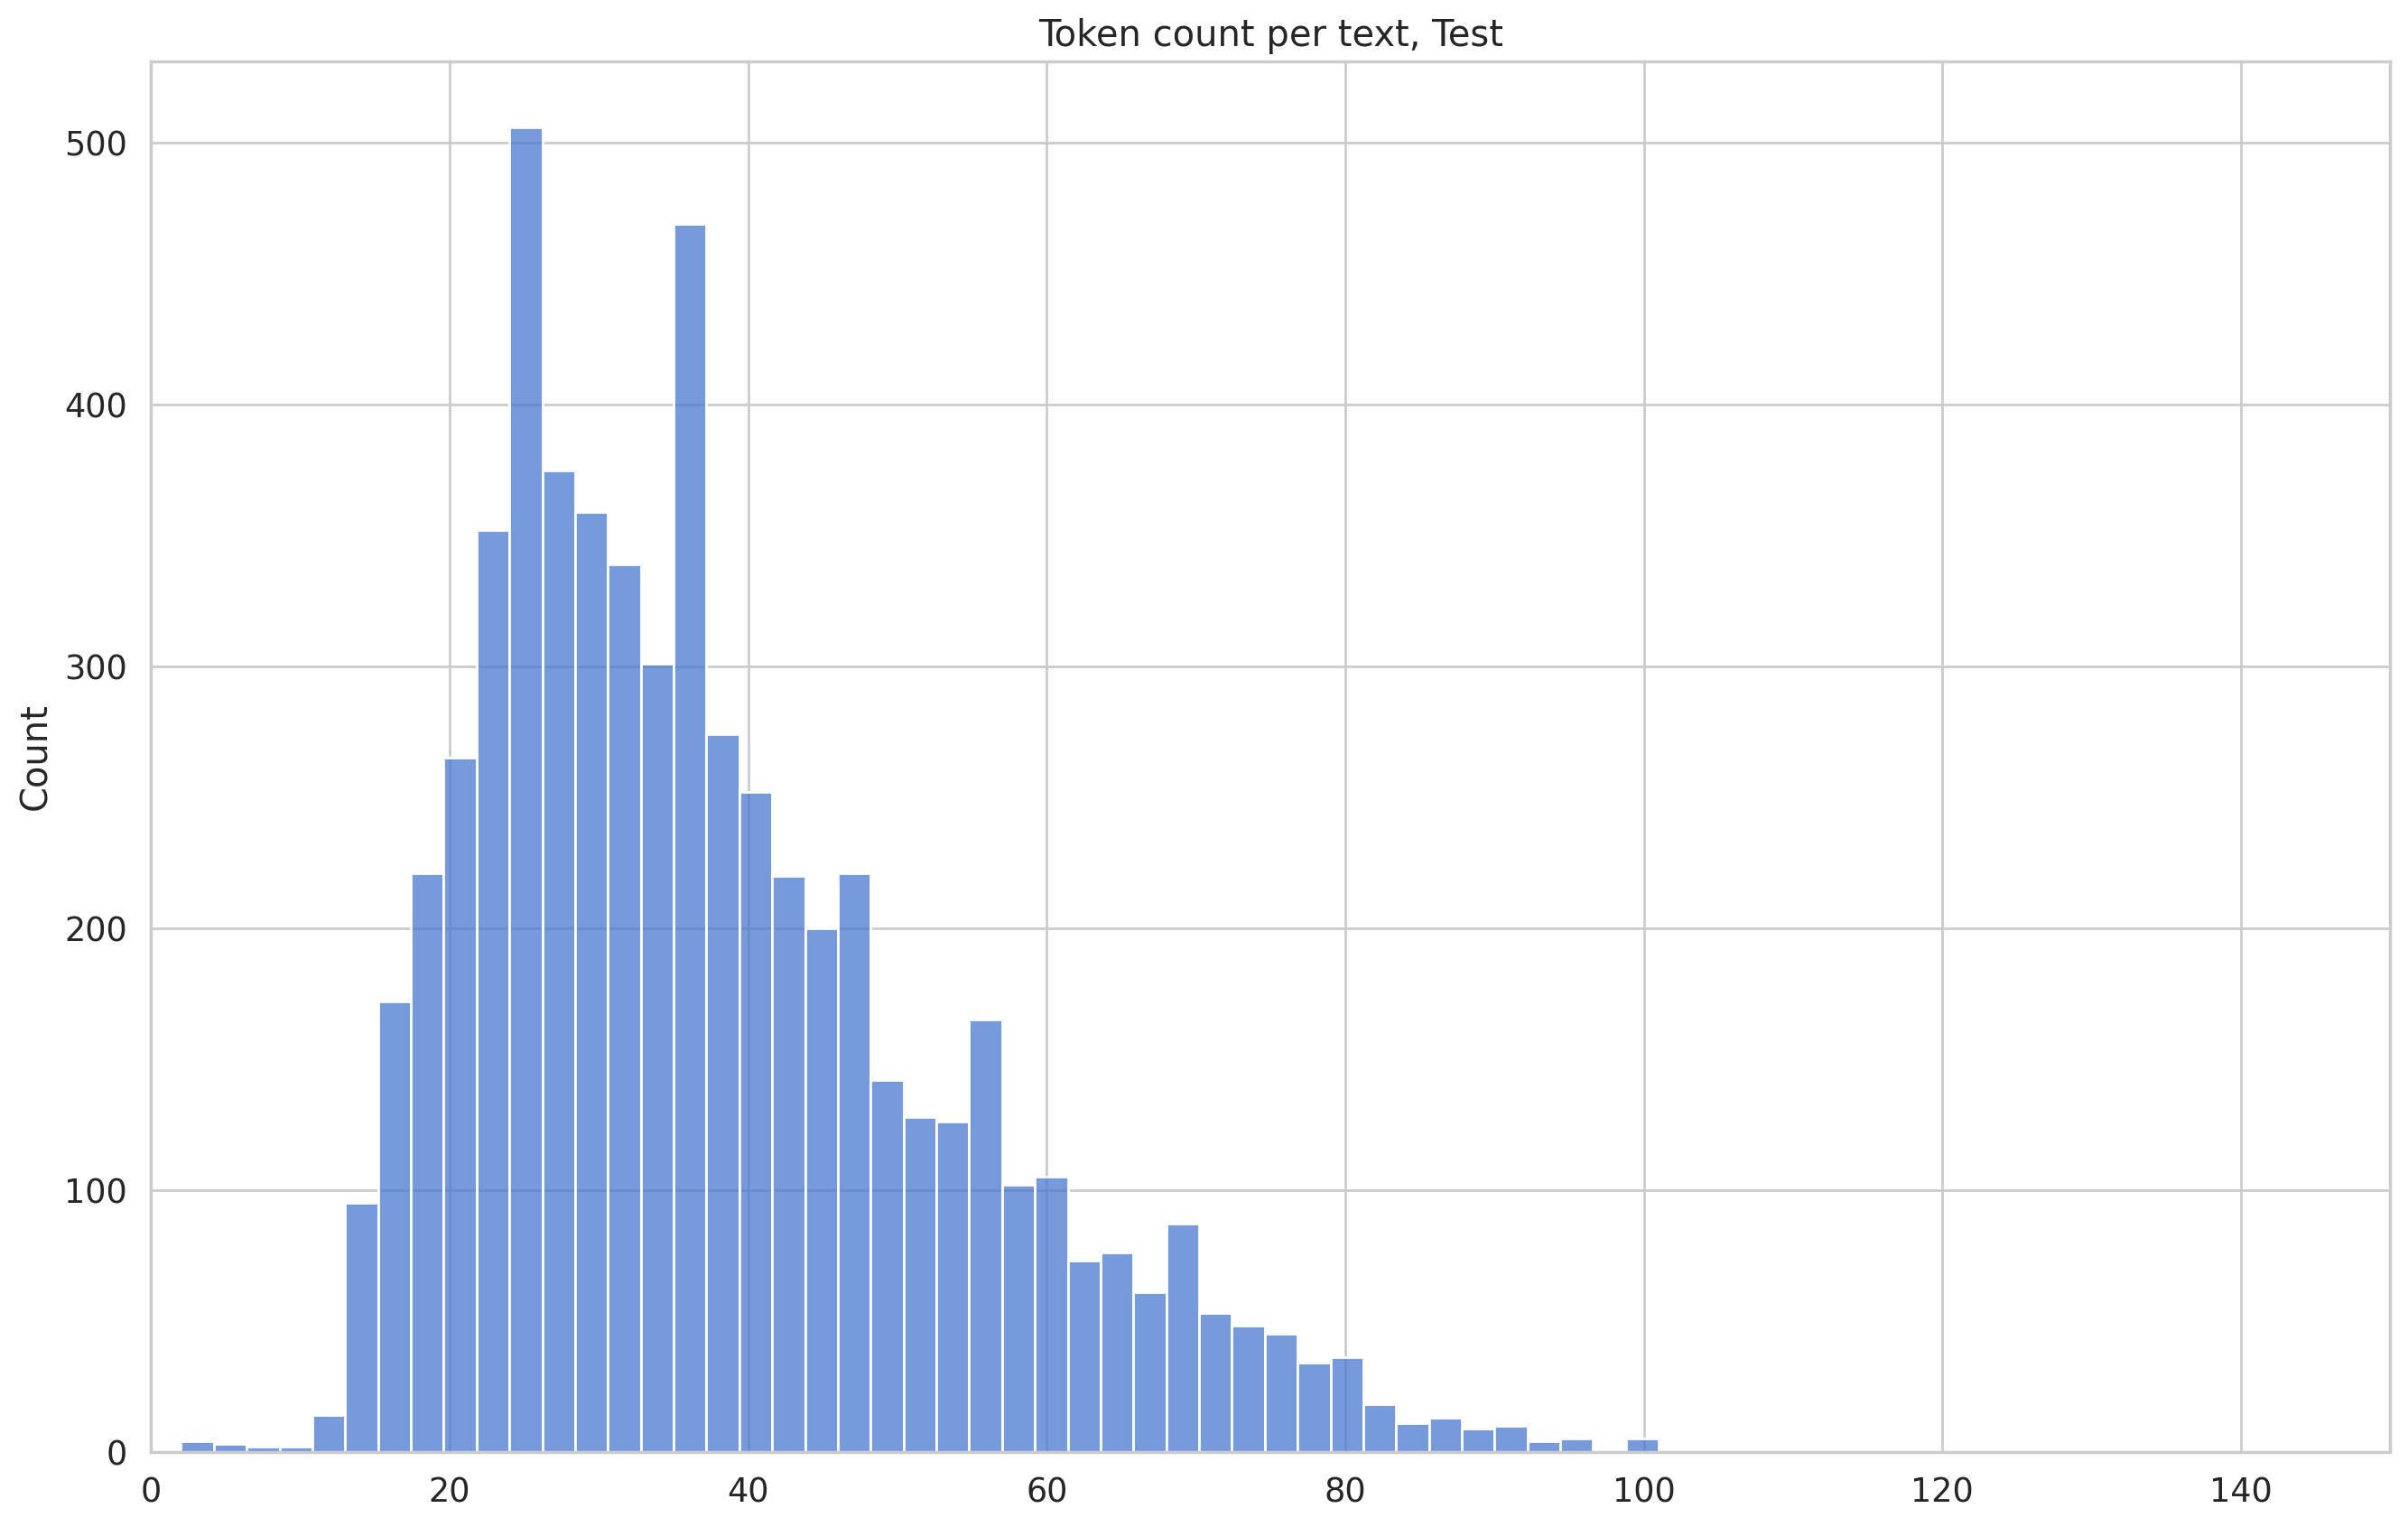

In [53]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["paragraph"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 150]);
plt.title("Token count per text, Test");

In [54]:
max(token_counts), min(token_counts), sum(token_counts) / len(token_counts)


(101, 2, 37.770576474508495)

In [55]:
## Parameters
max_length= 265
seednum= 123

## Define the dataset

In [56]:
# A class for the task, inherit from dataclass where we specifie id, name ,type,num_labels
@dataclass
class Task:
    id: int
    name: str
    type: str
    num_labels: int

In [57]:
train_df.columns

Index(['paragraph', 'LablePropaganda', 'LabelSentiment', 'LabelEmotion'], dtype='object')

### Propaganda Dataset

In [58]:
def load_propaganda_dataset():

    task_name = 'propaganda'
    num_labels =2  # {'false': 0, 'true': 1}
    task_id=1 # id of the task



#padding to ensure all input have same batch size which is necessary for batch processing.
#if the input is more than max length then it will be truncation otherwised it will be padding
#Task_id creates a list where each element is task_id, repeated for the length of examples['label'], this for MTL task
    def tokenize_text(examples):

        result = tokenizer(examples['paragraph'],
              padding='max_length',max_length=max_length, truncation=True,
        )
        result["task_ids"] = [task_id] * len(examples["label"])

        return result

    raw_datasets = loaded_datasets

    ## We need to rename the column to merge all the datasets later
    raw_datasets = raw_datasets.rename_column('LablePropaganda', 'label') # rename column

     # Tokenizing , and remove columns
    col_to_remove=['paragraph','LabelSentiment','LabelEmotion']

    train_dataset = raw_datasets["train"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)
    dev_dataset = raw_datasets["validation"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)
    test_dataset=raw_datasets["test"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)

    # Add task field
    task_info = Task(id=task_id, name=task_name, num_labels=num_labels, type="seq_classification" )



    return train_dataset,dev_dataset,test_dataset, task_info



In [59]:
load_propaganda_dataset()

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 6002
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 672
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 1326
 }),
 Task(id=1, name='propaganda', type='seq_classification', num_labels=2))

### Sentiment Dataset

In [60]:
def load_sentiment_dataset():

    task_name = 'sentiment'
    num_labels =3 # {'neutral': 0, 'positive': 1, 'negative':2}
    task_id=2


    def tokenize_text(examples):

        result = tokenizer(examples['paragraph'],
              padding='max_length',max_length=max_length, truncation=True,
        )
        result["task_ids"] = [task_id] * len(examples["label"])

        return result

    raw_datasets = loaded_datasets

    ## We need to rename the column to merge all the datasets later
    raw_datasets = raw_datasets.rename_column('LabelSentiment', 'label') # rename column

     # Tokenizing , and remove columns
    col_to_remove=['paragraph','LablePropaganda','LabelEmotion']

    train_dataset = raw_datasets["train"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)
    dev_dataset = raw_datasets["validation"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)
    test_dataset=raw_datasets["test"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)

    # Add task field
    task_info = Task(id=task_id, name=task_name, num_labels=num_labels, type="seq_classification" )



    return train_dataset,dev_dataset,test_dataset, task_info



In [61]:
load_sentiment_dataset()

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 6002
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 672
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 1326
 }),
 Task(id=2, name='sentiment', type='seq_classification', num_labels=3))

### Emotion Dataset

In [62]:
def load_emotion_dataset():

    task_name = 'emotion'
    num_labels =5 # {"none":0,"happiness":1,"sadness": 2,"anger": 3,"fear": 4}
    task_id=3


    def tokenize_text(examples):

        result = tokenizer(examples['paragraph'],
              padding='max_length',max_length=max_length, truncation=True,
        )
        result["task_ids"] = [task_id] * len(examples["label"])

        return result

    raw_datasets = loaded_datasets

    ## We need to rename the column to merge all the datasets later
    raw_datasets = raw_datasets.rename_column('LabelEmotion', 'label') # rename column

     # Tokenizing , and remove columns
    col_to_remove=['paragraph','LablePropaganda','LabelSentiment']

    train_dataset = raw_datasets["train"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)
    dev_dataset = raw_datasets["validation"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)
    test_dataset=raw_datasets["test"].map(tokenize_text,batched=True,load_from_cache_file=True,remove_columns=col_to_remove)

    # Add task field
    task_info = Task(id=task_id, name=task_name, num_labels=num_labels, type="seq_classification" )



    return train_dataset,dev_dataset,test_dataset, task_info



In [63]:
load_emotion_dataset()

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 6002
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 672
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
     num_rows: 1326
 }),
 Task(id=3, name='emotion', type='seq_classification', num_labels=5))

### Merging the 3 datasets

In [64]:
#def load_datasets(tokenizer, pad_to_max_length, max_seq_length, label_all_tokens, preprocessing_num_workers, overwrite_cache):

# Lubna's core point:
# The training datasets are MERGED to create a unified training set, which is beneficial for multi-task learning, as the model learns from all tasks at once.
# The validation and test datasets are APPENDED (not merged) to keep evaluation separate for each task, allowing task-specific metrics and more accurate validation.

def load_datasets():
    # Load three datasets and merge them to have only one dataset
    (
        seq_classification_train_dataset1,
        seq_classification_validation_dataset1,
        seq_classification_test_dataset1,
        seq_classification_task1,
    ) = load_propaganda_dataset()

    (
        seq_classification_train_dataset2,
        seq_classification_validation_dataset2,
        seq_classification_test_dataset2,
        seq_classification_task2,
    ) = load_sentiment_dataset()

    (
        seq_classification_train_dataset3,
        seq_classification_validation_dataset3,
        seq_classification_test_dataset3,
        seq_classification_task3,
    ) = load_emotion_dataset()

    # Merge train datasets
    train_dataset_df = pd.concat(
        [
            seq_classification_train_dataset1.to_pandas(),
            seq_classification_train_dataset2.to_pandas(),
            seq_classification_train_dataset3.to_pandas(),
        ],
        ignore_index=True
    )
    train_dataset = datasets.Dataset.from_pandas(train_dataset_df)
    train_dataset = train_dataset.shuffle(seed=seednum)


  # Append dev datasets
    validation_dataset= [
            seq_classification_validation_dataset1,
            seq_classification_validation_dataset2,
            seq_classification_validation_dataset3,
    ]
    # Append test datasets
    test_dataset = [
        seq_classification_test_dataset1,
        seq_classification_test_dataset2,
        seq_classification_test_dataset3
    ]

    # Create a dataset dictionary
    dataset = datasets.DatasetDict(
        {
            "train": train_dataset,
            "dev": validation_dataset,
            "test": test_dataset
        }
    )

    tasks = [seq_classification_task1, seq_classification_task2, seq_classification_task3]

    return tasks, dataset


# Multi-Task Model

1. Create attention heads
2. Define the encoder
3. Build multi-task model

### Propaganda Head

In [65]:
# class SequenceClassificationHeadPropaganda(nn.Module):

#     def __init__(self, hidden_size, num_labels, dropout_p=0.1):
#         super().__init__()
#         self.num_labels = num_labels
#         self.dropout = nn.Dropout(dropout_p)
#         self.classifier = nn.Linear(hidden_size, num_labels)

#         self._init_weights()

#     #def forward(self, sequence_output, pooled_output, labels=None, **kwargs):
#     def forward(self,pooled_output, labels=None, **kwargs):
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         loss = None
#         if labels is not None:
# #             if labels.dim() != 1:
# #                 # Remove padding
# #                 labels = labels[:, 0]

#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(
#                 logits.view(-1, self.num_labels), labels.long().view(-1)
#             )
#             wandb.log({'Sarcasm_loss': loss})

#         return logits, loss

#     def _init_weights(self):
#         self.classifier.weight.data.normal_(mean=0.0, std=0.02)
#         if self.classifier.bias is not None:
#             self.classifier.bias.data.zero_()


In [66]:
class SequenceClassificationHeadPropaganda(nn.Module):

  def __init__(self, hidden_size, num_labels=1, dropout_p=0.1):

          super().__init__()
          self.num_labels = num_labels

          self.dropout = nn.Dropout(dropout_p)
          self.classifier = nn.Linear(hidden_size, 1)

          self._init_weights()

      #def forward(self, sequence_output, pooled_output, labels=None, **kwargs):
  def forward(self, pooled_output, labels=None, **kwargs):
      pooled_output = self.dropout(pooled_output)
      logits = self.classifier(pooled_output)

      # print(f"Lubna Logits shape: {logits.shape}")
      # if labels is not None:
      #     print(f"Lubna Target shape: {labels.shape}")

      loss = None
      if labels is not None:



            # Ensure logits are also flattened properly
            loss_fct = nn.BCEWithLogitsLoss() #only expected 1D
            loss = loss_fct(
                logits.view(-1), labels.float().view(-1)
            )
            wandb.log({'Propaganda_loss': loss})

      return logits, loss

  def _init_weights(self):
          self.classifier.weight.data.normal_(mean=0.0, std=0.02)
          if self.classifier.bias is not None:
              self.classifier.bias.data.zero_()


In [67]:
# import torch
# import torch.nn as nn


# # Define the Focal Loss for binary classification
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, logits, targets):
#         # Binary Cross Entropy with logits as base loss
#         BCE_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='mean')

#         # Compute probability of the correct class
#         pt = torch.exp(-BCE_loss)

#         # Apply the focal loss formula
#         F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

#         if self.reduction == 'mean':
#             return F_loss.mean()
#         elif self.reduction == 'sum':
#             return F_loss.sum()
#         else:
#             return F_loss


# class SequenceClassificationHeadPropaganda(nn.Module):
#     def __init__(self, hidden_size, num_labels=1, dropout_p=0.1):
#         super().__init__()
#         self.num_labels = num_labels
#         self.dropout = nn.Dropout(dropout_p)
#         self.classifier = nn.Linear(hidden_size, 1)
#         self._init_weights()

#     def forward(self, pooled_output, labels=None, **kwargs):
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         loss = None
#         if labels is not None:
#             # Use Focal Loss instead of BCEWithLogitsLoss
#             loss_fct = FocalLoss(alpha=0.25, gamma=2.0)

#             # Compute focal loss
#             loss = loss_fct(logits.view(-1), labels.float().view(-1))
#             wandb.log({'Propaganda_loss': loss})

#         return logits, loss

#     def _init_weights(self):
#         self.classifier.weight.data.normal_(mean=0.0, std=0.02)
#         if self.classifier.bias is not None:
#             self.classifier.bias.data.zero_()


### Sentiment Head

In [68]:
class SequenceClassificationHeadSentiment(nn.Module):

    def __init__(self, hidden_size, num_labels, dropout_p=0.1):
        super().__init__()
        self.num_labels = num_labels
        #0.1 means there's a 10% chance of each neuron being set to zero during training
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(hidden_size, num_labels)

        self._init_weights()

    #def forward(self, sequence_output, pooled_output, labels=None, **kwargs):
    def forward(self,pooled_output, labels=None, **kwargs):
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)  # Shape output: [batch_size, number of class]

        loss = None
        if labels is not None:
#             if labels.dim() != 1:
#                 # Remove padding
#                 labels = labels[:, 0]

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                logits.view(-1, self.num_labels), labels.long().view(-1)
            )
            wandb.log({'Sentiment_loss': loss})

        return logits, loss

    def _init_weights(self):
        self.classifier.weight.data.normal_(mean=0.0, std=0.02)
        if self.classifier.bias is not None:
            self.classifier.bias.data.zero_()


In [69]:
# import torch
# import torch.nn as nn
# # Define Focal Loss for multi-class classification
# class FocalLossMultiClass(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         super(FocalLossMultiClass, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, logits, targets):
#         # Cross Entropy Loss as base loss
#         CE_loss = nn.functional.cross_entropy(logits, targets, reduction='mean')

#         # Get the probability of the correct class
#         pt = torch.exp(-CE_loss)

#         # Apply the focal loss formula
#         F_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

#         if self.reduction == 'mean':
#             return F_loss.mean()
#         elif self.reduction == 'sum':
#             return F_loss.sum()
#         else:
#             return F_loss

# class SequenceClassificationHeadSentiment(nn.Module):
#     def __init__(self, hidden_size, num_labels, dropout_p=0.1):
#         super().__init__()
#         self.num_labels = num_labels
#         self.dropout = nn.Dropout(dropout_p)
#         self.classifier = nn.Linear(hidden_size, num_labels)
#         self._init_weights()

#     def forward(self, pooled_output, labels=None, **kwargs):
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)  # Shape output: [batch_size, number of class]

#         loss = None
#         if labels is not None:
#             # Use Focal Loss instead of CrossEntropyLoss
#             loss_fct = FocalLossMultiClass(alpha=0.25, gamma=2.0)
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.long().view(-1))
#             wandb.log({'Sentiment_loss': loss})

#         return logits, loss

#     def _init_weights(self):
#         self.classifier.weight.data.normal_(mean=0.0, std=0.02)
#         if self.classifier.bias is not None:
#             self.classifier.bias.data.zero_()


### Emotion Head

In [70]:
class SequenceClassificationHeadEmotion(nn.Module):

    def __init__(self, hidden_size, num_labels, dropout_p=0.1):
        super().__init__()
        self.num_labels = num_labels
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(hidden_size, num_labels)

        self._init_weights()

    #def forward(self, sequence_output, pooled_output, labels=None, **kwargs):
    def forward(self,pooled_output, labels=None, **kwargs):
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            # if labels.dim() != 1:
            #     # Remove padding
            #     labels = labels[:, 0]

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                logits.view(-1, self.num_labels), labels.long().view(-1)
            )
            wandb.log({'Emotion_loss': loss})

        return logits, loss

    def _init_weights(self):
        self.classifier.weight.data.normal_(mean=0.0, std=0.02)
        if self.classifier.bias is not None:
            self.classifier.bias.data.zero_()


In [71]:
# class FocalLossMultiClass(nn.Module): #Focal Loss
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         super(FocalLossMultiClass, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, logits, targets):
#         # Cross Entropy Loss as base loss
#         CE_loss = nn.functional.cross_entropy(logits, targets, reduction='mean')

#         # Get the probability of the correct class
#         pt = torch.exp(-CE_loss)

#         # Apply the focal loss formula
#         F_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

#         if self.reduction == 'mean':
#             return F_loss.mean()
#         elif self.reduction == 'sum':
#             return F_loss.sum()
#         else:
#             return F_loss

# class SequenceClassificationHeadEmotion(nn.Module):
#     def __init__(self, hidden_size, num_labels, dropout_p=0.1):
#         super().__init__()
#         self.num_labels = num_labels
#         self.dropout = nn.Dropout(dropout_p)
#         self.classifier = nn.Linear(hidden_size, num_labels)

#         self._init_weights()

#     def forward(self, pooled_output, labels=None, **kwargs):
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         loss = None
#         if labels is not None:
#             # Use Focal Loss instead of CrossEntropyLoss
#             loss_fct = FocalLossMultiClass(alpha=0.25, gamma=2.0)
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.long().view(-1))
#             wandb.log({'Emotion_loss': loss})

#         return logits, loss

#     def _init_weights(self):
#         self.classifier.weight.data.normal_(mean=0.0, std=0.02)
#         if self.classifier.bias is not None:
#             self.classifier.bias.data.zero_()


### Multi-task class

In [72]:
class MultiTaskModel(nn.Module):
    def __init__(self, selectedModel, tasks: List):
        super().__init__()

        ## Define the encoder which is transformer model used for shared layer
        self.encoder = AutoModel.from_pretrained(selectedModel)

        '''
        encoder = self.tokenizer.encode_plus(
            target,
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True, # to make sure each sequence is maximum of max length
            return_tensors='pt', #return it as pytorch
        )
        '''
#ModuleDict it is PyTorch structure that allows to store multiple layers (heads) with different configurations.
        self.output_heads = nn.ModuleDict() #
        for task in tasks:
            decoder = self._create_output_head(self.encoder.config.hidden_size, task)
            # ModuleDict requires keys to be strings
#The model processes multiple tasks in one batch. For each unique task in the batch, it selects the appropriate head from self.output_heads

            self.output_heads[str(task.id)] = decoder

    @staticmethod
    def _create_output_head(encoder_hidden_size: int, task): #create output head for each task
        if task.name == "propaganda":
            return SequenceClassificationHeadPropaganda(encoder_hidden_size, task.num_labels)
        elif task.name == "sentiment":
            return SequenceClassificationHeadSentiment(encoder_hidden_size, task.num_labels)
        elif task.name == "emotion":
            return SequenceClassificationHeadEmotion(encoder_hidden_size, task.num_labels)
        else:
            raise NotImplementedError()

    def forward(
        self,
        input_ids=None, #Tokenized input text (from BERT tokenizer).
        attention_mask=None,#Mask to indicate which tokens are actual words and which are padding tokens.
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        task_ids=None,
        **kwargs,
    ):

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        '''

        The [CLS] token is a special token added at the beginning of every input sentence,
        and its corresponding hidden state (the final output of the [CLS] token after all transformer layers)

        So, Lubna we can have token or the sentence-level representation, so output[1] for  [CLS]where output[0] for token
        that means since we consider sentance level we take the embedding for whole sentence

        sequence_output, pooled_output = outputs[:2]# sequence_output  are the hidden representations of all tokens


        The filtered inputs (pooled_output, labels, and attention_mask) are passed to the corresponding task-specific head for classification or regression.
        '''
        pooled_output = outputs[1]
        # pooler layer takes the final hidden representation of the [CLS] token (this is a vector of size 768),
        #then applies a linear layer and tanh to it
        # pooled_output=[batch_size, 768]



        #As we processes a batch of inputs and filters the inputs based on task IDs to apply task-specific heads for each unique task in the batch
        #This allows the model to process only the samples relevant to the current task, instead of processing the entire batch all at once.
        unique_task_ids_list = torch.unique(task_ids).tolist()# unique_task_ids_list=[1,2,3] ,task_ids=[1,2,3,1,1,2,1]

        loss_list = []
        logits = None


        for unique_task_id in unique_task_ids_list:
            #task_id_filter is used to filter only the task in hand from the batch for example
            #boolean mask that filters the samples corresponding to the current task
            #For example, if unique_task_id = 3 and task_ids = [1, 2, 3, 1, 1, 2, 1], then task_id_filter would be: tensor([False, False, True, False, False, False, False])

            task_id_filter = task_ids == unique_task_id

            '''Task-Specific Head: The model selects the task-specific output head for the current task
              using self.output_heads[str(unique_task_id)]. For example, if unique_task_id = 1,
              this might refer to the propaganda classification head.

              Forward Pass: The task-specific head processes the filtered data:

              ** pooled_output[task_id_filter]: The sentence-level representation from the shared encoder, but only for the samples corresponding to the current task.
              ** labels[task_id_filter]: The ground-truth labels, but only for the current task's samples (used for calculating the loss).
              ** attention_mask[task_id_filter]: The attention mask, also filtered for the current task's samples.
            '''

            logits, task_loss = self.output_heads[str(unique_task_id)].forward(
                #sequence_output[task_id_filter],# size of (batch_size, hidden_size) for our case (32,768)
                pooled_output[task_id_filter],# size of (batch_size, hidden_size) for our case (32,768)
                labels=None if labels is None else labels[task_id_filter],
                attention_mask=attention_mask[task_id_filter],
            )

            if labels is not None:
                loss_list.append(task_loss)

        # logits are only used for eval. and in case of eval the batch is not multi task
        # For training only the loss is used
        # outputs[2:] is the same as outputs[1] --> try it first
#The outputs[2:] extracts any additional outputs provided by the BERT encoder such as attention wights
        outputs = (logits, outputs[2:])

        if loss_list:
            #Lubna the aim of stack is to stacks the losses into a tensor.
            loss = torch.stack(loss_list)
            outputs = (loss.mean(),) + outputs
            #outputs = (loss.sum(),) + outputs
            wandb.log({'Loss Mean': loss.mean()})

        return outputs

        '''
        The global loss is calculated once per batch.
        Return Values outputs = (0.7771 (Global loss), logits, additional_outputs)
        If in evaluation mode (no labels), the method returns logits for predictions.
        If in training mode (labels are provided), it also returns the combined loss for all tasks.'''




# Training

In [73]:
# Import for trainer

from transformers import Trainer, DataCollatorWithPadding
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)


### Loading for training

In [74]:
# Load the multi task dataset
tasks, dataset=load_datasets()

# Build the multi task model
model=MultiTaskModel(selectedModel,tasks)

## pad_to_multiple_of=8 --> this just for the GPU during training
data_collator = DataCollatorWithPadding(
                        tokenizer, pad_to_multiple_of=8
                    )

# Load the train and validation dataset
train_dataset = dataset["train"]


#
devpropaganda, devsentiment, devemotion = dataset['dev']


# Load the test dataset
testpropaganda, testsentiment, testemotion = dataset['test']
#validstance, validsarcasm = dataset['validation']


Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--UBC-NLP--MARBERT/snapshots/88e1fa192dd723cf0b3563500aec46209762eb22/pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassi

In [75]:
# We should have 1 merged dataset and 3 validation sets (one for each task)
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 18006
    })
    dev: [Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 672
    }), Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 672
    }), Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 672
    })]
    test: [Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 1326
    }), Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 1326
    }), Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'task_ids'],
        num_rows: 1326
    })]
})

### Define metrics

In [76]:
def compute_metrics(p: EvalPrediction):



        # Apply sigmoid to logits to get probabilities for binary classification
    # pt.predictions is an array of shape [num_samples, 1] for binary classification
    preds_prob_dev = torch.sigmoid(torch.tensor(p.predictions[0]))

    # Threshold the probabilities at 0.5 to get the predicted class (0 or 1)
    preds  = (preds_prob_dev >= 0.5).long().numpy().flatten()

    # Actual labels (ground truth)
    target = p.label_ids


    # # I change this beacuse it is for multi-class

    # preds = np.argmax(p.predictions[0],axis=1)
    # target=p.label_ids
    # #print(classification_report(target,preds))

    return {
            "precision": round(precision_score(target, preds, average='macro'),4),
            "recall": round(recall_score(target, preds, average='macro'),4),
            "macro_f1": round(f1_score(target, preds, average='macro'),4),
            "micro_f1": round(f1_score(target, preds, average='micro'),4),
            "accuracy": round(accuracy_score(target, preds),4),
        }

### Logging to WANDB

In [77]:
!pip install wandb

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [78]:
import wandb



In [79]:
wandb.login()

#59e2d66d952a75899f052f81838e5677c90c34cc

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lubna-sulieman (lubna-sulieman-king-saud-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [80]:
# Initialize a new run
wandb.init(project="Lubna_MTL_BASE_NEW",name = Ex_name)

# Using many seed in one code + Evaluation

In [87]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Define different seed values
seed_values = [42, 141, 1012, 342, 789]

# Define function to set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Store results
all_results = []

for seed in seed_values:
    print(f"Running training with seed {seed}")

    set_seed(seed)

    training_args = TrainingArguments(
        output_dir=f"./models_seed_{seed}",
        overwrite_output_dir=True,
        learning_rate=2e-5,
        weight_decay=0.001,
        adam_epsilon=1e-8,
        fp16=True,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='macro_f1',
        greater_is_better=True,
        seed=seed,
    )

    class CustomTrainer(Trainer):
        def save_model(self, output_dir=None, _internal_call=False):
            """Override the default save_model behavior to handle shared parameters correctly."""
            if output_dir is None:
                output_dir = self.args.output_dir

            # Ensure directory exists
            os.makedirs(output_dir, exist_ok=True)

            # Save model's state_dict without redundant shared parameters
            torch.save(self.model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

            # Save tokenizer separately if available
            if self.tokenizer is not None:
                self.tokenizer.save_pretrained(output_dir)

            print(f"Model saved successfully to {output_dir}")

    # Use CustomTrainer instead of Trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=devpropaganda,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )


    # Train the model
    trainer.train()
    torch.cuda.empty_cache()


    pred_test = trainer.predict(testpropaganda)
    preds_prob_test = torch.sigmoid(torch.tensor(pred_test.predictions[0]))
    preds_test = (preds_prob_test >= 0.5).long().numpy().flatten()
    label_test = pred_test.label_ids

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(label_test, preds_test, average='macro')
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(label_test, preds_test, average='micro')
    acc = accuracy_score(label_test, preds_test)

    all_results.append({
        'Seed': seed,
        'Accuracy': acc,
        'Macro F1': f1_macro,
        'Micro F1': f1_micro,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Micro)': recall_micro
    })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_excel("ComparativeStudyMTL_Seed_results.xlsx", index=False)


# Define source and destination paths
source_path = '/content/ComparativeStudyMTL_Seed_results.xlsx'  # File in Colab storage
destination_path = '/content/drive/My Drive//Colab Notebooks/MTL Results/ComparativeStudyMTL_Seed_results.xlsx'  # Target location in Google Drive

# Move the file to Google Drive
shutil.move(source_path, destination_path)

print(f"File moved to: {destination_path}")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
<ipython-input-88-9d115d9bd6ec>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
Using auto half precision backend


Running training with seed 42


***** Running training *****
  Num examples = 18,006
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11,255
  Number of trainable parameters = 162,848,265
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an AttributeError.


Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1,Micro F1,Accuracy
1,0.557900,0.506578,0.756800,0.674400,0.682100,0.742600,0.742600
2,0.498000,0.508026,0.786400,0.775000,0.779800,0.799100,0.799100
3,0.265600,0.928220,0.777600,0.768300,0.772300,0.791700,0.791700
4,0.130100,1.098925,0.755400,0.751300,0.753200,0.772300,0.772300
5,0.045200,1.178497,0.763300,0.761400,0.762300,0.779800,0.779800



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_42/checkpoint-2251/tokenizer_config.json
Special tokens file saved in ./models_seed_42/checkpoint-2251/special_tokens_map.json


Model saved successfully to ./models_seed_42/checkpoint-2251



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_42/checkpoint-4502/tokenizer_config.json
Special tokens file saved in ./models_seed_42/checkpoint-4502/special_tokens_map.json


Model saved successfully to ./models_seed_42/checkpoint-4502



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_42/checkpoint-6753/tokenizer_config.json
Special tokens file saved in ./models_seed_42/checkpoint-6753/special_tokens_map.json


Model saved successfully to ./models_seed_42/checkpoint-6753



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_42/checkpoint-9004/tokenizer_config.json
Special tokens file saved in ./models_seed_42/checkpoint-9004/special_tokens_map.json


Model saved successfully to ./models_seed_42/checkpoint-9004



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_42/checkpoint-11255/tokenizer_config.json
Special tokens file saved in ./models_seed_42/checkpoint-11255/special_tokens_map.json


Model saved successfully to ./models_seed_42/checkpoint-11255




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./models_seed_42/checkpoint-4502 (score: 0.7798).

***** Running Prediction *****
  Num examples = 1326
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
<ipython-input-88-9d115d9bd6ec>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
Using auto half precision backend


Running training with seed 141


***** Running training *****
  Num examples = 18,006
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11,255
  Number of trainable parameters = 162,848,265
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an AttributeError.


Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1,Micro F1,Accuracy
1,0.369100,0.873017,0.760200,0.765900,0.762600,0.776800,0.776800
2,0.256700,1.100035,0.735900,0.743700,0.738900,0.753000,0.753000
3,0.133300,1.360957,0.778000,0.741800,0.752200,0.782700,0.782700
4,0.091400,1.412669,0.764800,0.764300,0.764500,0.781200,0.781200
5,0.014000,1.431731,0.781900,0.775200,0.778200,0.796100,0.796100



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_141/checkpoint-2251/tokenizer_config.json
Special tokens file saved in ./models_seed_141/checkpoint-2251/special_tokens_map.json


Model saved successfully to ./models_seed_141/checkpoint-2251



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_141/checkpoint-4502/tokenizer_config.json
Special tokens file saved in ./models_seed_141/checkpoint-4502/special_tokens_map.json


Model saved successfully to ./models_seed_141/checkpoint-4502



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_141/checkpoint-6753/tokenizer_config.json
Special tokens file saved in ./models_seed_141/checkpoint-6753/special_tokens_map.json


Model saved successfully to ./models_seed_141/checkpoint-6753



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_141/checkpoint-9004/tokenizer_config.json
Special tokens file saved in ./models_seed_141/checkpoint-9004/special_tokens_map.json


Model saved successfully to ./models_seed_141/checkpoint-9004



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_141/checkpoint-11255/tokenizer_config.json
Special tokens file saved in ./models_seed_141/checkpoint-11255/special_tokens_map.json


Model saved successfully to ./models_seed_141/checkpoint-11255




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./models_seed_141/checkpoint-11255 (score: 0.7782).

***** Running Prediction *****
  Num examples = 1326
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
<ipython-input-88-9d115d9bd6ec>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
Using auto half precision backend


Running training with seed 1012


***** Running training *****
  Num examples = 18,006
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11,255
  Number of trainable parameters = 162,848,265
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an AttributeError.


Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1,Micro F1,Accuracy
1,0.240800,1.479320,0.762900,0.747200,0.753100,0.776800,0.776800
2,0.058600,1.765059,0.761600,0.766200,0.763700,0.778300,0.778300
3,0.034700,1.860514,0.762100,0.769600,0.765100,0.778300,0.778300
4,0.039900,1.858208,0.772800,0.763100,0.767200,0.787200,0.787200
5,0.021600,1.856589,0.771300,0.769900,0.770600,0.787200,0.787200



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_1012/checkpoint-2251/tokenizer_config.json
Special tokens file saved in ./models_seed_1012/checkpoint-2251/special_tokens_map.json


Model saved successfully to ./models_seed_1012/checkpoint-2251



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_1012/checkpoint-4502/tokenizer_config.json
Special tokens file saved in ./models_seed_1012/checkpoint-4502/special_tokens_map.json


Model saved successfully to ./models_seed_1012/checkpoint-4502



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_1012/checkpoint-6753/tokenizer_config.json
Special tokens file saved in ./models_seed_1012/checkpoint-6753/special_tokens_map.json


Model saved successfully to ./models_seed_1012/checkpoint-6753



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_1012/checkpoint-9004/tokenizer_config.json
Special tokens file saved in ./models_seed_1012/checkpoint-9004/special_tokens_map.json


Model saved successfully to ./models_seed_1012/checkpoint-9004



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_1012/checkpoint-11255/tokenizer_config.json
Special tokens file saved in ./models_seed_1012/checkpoint-11255/special_tokens_map.json


Model saved successfully to ./models_seed_1012/checkpoint-11255




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./models_seed_1012/checkpoint-11255 (score: 0.7706).

***** Running Prediction *****
  Num examples = 1326
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
<ipython-input-88-9d115d9bd6ec>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
Using auto half precision backend


Running training with seed 342


***** Running training *****
  Num examples = 18,006
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11,255
  Number of trainable parameters = 162,848,265
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an AttributeError.


Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1,Micro F1,Accuracy
1,0.079000,1.833839,0.747300,0.743700,0.745400,0.764900,0.764900
2,0.132000,2.012387,0.754100,0.760300,0.756700,0.770800,0.770800
3,0.000300,2.112504,0.757200,0.751700,0.754200,0.773800,0.773800
4,0.006500,2.198287,0.746100,0.738300,0.741600,0.763400,0.763400
5,0.000100,2.196889,0.753800,0.749300,0.751400,0.770800,0.770800



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_342/checkpoint-2251/tokenizer_config.json
Special tokens file saved in ./models_seed_342/checkpoint-2251/special_tokens_map.json


Model saved successfully to ./models_seed_342/checkpoint-2251



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_342/checkpoint-4502/tokenizer_config.json
Special tokens file saved in ./models_seed_342/checkpoint-4502/special_tokens_map.json


Model saved successfully to ./models_seed_342/checkpoint-4502



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_342/checkpoint-6753/tokenizer_config.json
Special tokens file saved in ./models_seed_342/checkpoint-6753/special_tokens_map.json


Model saved successfully to ./models_seed_342/checkpoint-6753



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_342/checkpoint-9004/tokenizer_config.json
Special tokens file saved in ./models_seed_342/checkpoint-9004/special_tokens_map.json


Model saved successfully to ./models_seed_342/checkpoint-9004



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_342/checkpoint-11255/tokenizer_config.json
Special tokens file saved in ./models_seed_342/checkpoint-11255/special_tokens_map.json


Model saved successfully to ./models_seed_342/checkpoint-11255




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./models_seed_342/checkpoint-4502 (score: 0.7567).

***** Running Prediction *****
  Num examples = 1326
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
<ipython-input-88-9d115d9bd6ec>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
Using auto half precision backend


Running training with seed 789


***** Running training *****
  Num examples = 18,006
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11,255
  Number of trainable parameters = 162,848,265
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an AttributeError.


Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1,Micro F1,Accuracy
1,0.057300,1.929183,0.758000,0.736600,0.743900,0.770800,0.770800
2,0.075600,1.922445,0.745500,0.757200,0.749100,0.760400,0.760400
3,0.024000,2.095809,0.733000,0.735700,0.734300,0.751500,0.751500
4,0.037900,2.188771,0.747200,0.748800,0.748000,0.764900,0.764900
5,0.000100,2.256991,0.746300,0.737500,0.741100,0.763400,0.763400



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_789/checkpoint-2251/tokenizer_config.json
Special tokens file saved in ./models_seed_789/checkpoint-2251/special_tokens_map.json


Model saved successfully to ./models_seed_789/checkpoint-2251



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_789/checkpoint-4502/tokenizer_config.json
Special tokens file saved in ./models_seed_789/checkpoint-4502/special_tokens_map.json


Model saved successfully to ./models_seed_789/checkpoint-4502



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_789/checkpoint-6753/tokenizer_config.json
Special tokens file saved in ./models_seed_789/checkpoint-6753/special_tokens_map.json


Model saved successfully to ./models_seed_789/checkpoint-6753



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_789/checkpoint-9004/tokenizer_config.json
Special tokens file saved in ./models_seed_789/checkpoint-9004/special_tokens_map.json


Model saved successfully to ./models_seed_789/checkpoint-9004



***** Running Evaluation *****
  Num examples = 672
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
tokenizer config file saved in ./models_seed_789/checkpoint-11255/tokenizer_config.json
Special tokens file saved in ./models_seed_789/checkpoint-11255/special_tokens_map.json


Model saved successfully to ./models_seed_789/checkpoint-11255




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./models_seed_789/checkpoint-4502 (score: 0.7491).

***** Running Prediction *****
  Num examples = 1326
  Batch size = 8


File moved to: /content/drive/My Drive//Colab Notebooks/MTL Results/ComparativeStudyMTL_Seed_results.xlsx


### Using Grid Search

In [ ]:
# Focal Loss


# from itertools import product
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# # Define the grid of hyperparameters for Focal Loss
# alpha_values = [0.1, 0.25, 0.5]
# gamma_values = [1.0, 2.0, 3.0]
# reduction_values = ['mean', 'sum']

# # Create combinations of alpha, gamma, and reduction
# param_grid = list(product(alpha_values, gamma_values, reduction_values))

# best_params = None
# best_f1 = 0

# # Iterate over each combination of hyperparameters
# for alpha, gamma, reduction in param_grid:
#     print(f"Training with alpha={alpha}, gamma={gamma}, reduction={reduction}")

#     # Define Focal Loss with the current hyperparameters
#     loss_fct = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction)

#     # Define the training arguments
#     training_args = transformers.TrainingArguments(
#         output_dir="./models",
#         overwrite_output_dir=True,
#         learning_rate=2e-5,
#         weight_decay=1e-4,
#         fp16=True,
#         num_train_epochs=5,
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         gradient_accumulation_steps=8,
#         logging_steps=100,
#         evaluation_strategy='epoch',
#         save_strategy='epoch',
#         load_best_model_at_end=True,
#         metric_for_best_model='macro_f1',
#         greater_is_better=True,
#         seed=42,
#         report_to="wandb",
#         run_name=f"FocalLoss_alpha_{alpha}_gamma_{gamma}_reduction_{reduction}",
#     )

#     # Initialize the trainer with the current focal loss
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=devpropaganda,  # Use the appropriate validation set
#         compute_metrics=compute_metrics,  # Evaluation metrics function
#         tokenizer=tokenizer,
#         data_collator=data_collator,
#     )

#     # Train the model
#     trainer.train()

#     # Evaluate the model on the validation set
#     metrics = trainer.evaluate(eval_dataset=devpropaganda)
#     f1 = metrics['eval_macro_f1']  # Use F1 score as a comparison metric

#     # Track the best hyperparameters based on F1 score
#     if f1 > best_f1:
#         best_f1 = f1
#         best_params = (alpha, gamma, reduction)

#     print(f"Validation F1 Score: {f1}")

# print(f"Best Hyperparameters: Alpha={best_params[0]}, Gamma={best_params[1]}, Reduction={best_params[2]} with F1 Score={best_f1}")


In [ ]:
# # Wight decy


# from transformers import Trainer, TrainingArguments

# # Fixed values for alpha, gamma, and reduction
# alpha = 0.25
# gamma = 2.0
# reduction = 'mean'

# # Only tune weight decay values
# weight_decay_values = [0.0, 1e-5, 1e-4, 0.001, 0.01, 0.05, 0.1]

# best_params = None
# best_f1 = 0
# total_runs = len(weight_decay_values)  # Total number of runs
# current_run = 1  # Initialize counter for current run

# # Iterate over each weight_decay value
# for weight_decay in weight_decay_values:
#     print(f"Run {current_run}/{total_runs}: Training with weight_decay={weight_decay}")

#     # Define the dynamic training arguments
#     training_args = TrainingArguments(
#      output_dir="./models",
#         overwrite_output_dir=True,
#         learning_rate=2e-5,
#         #weight_decay=1e-4,
#         fp16=True,
#         num_train_epochs=5,
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         gradient_accumulation_steps=8,
#         logging_steps=100,
#         evaluation_strategy='epoch',
#         save_strategy='epoch',
#         load_best_model_at_end=True,
#         metric_for_best_model='macro_f1',
#         greater_is_better=True,
#         seed=42,
#         report_to="wandb",
#         run_name = Ex_name,
#     )

#     # Initialize the Trainer with the model and dynamically pass the fixed Focal Loss hyperparameters
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=devpropaganda,  # Use the appropriate validation set
#         compute_metrics=compute_metrics,  # Evaluation metrics function
#         tokenizer=tokenizer,
#         data_collator=data_collator,
#     )

#     # Train the model and evaluate
#     trainer.train()
#     metrics = trainer.evaluate()

#     # Log the evaluation metric (e.g., F1 score) for this configuration
#     f1 = metrics.get('eval_f1', 0)
#     print(f"Validation F1 Score with weight_decay={weight_decay}: {f1}")

#     # Track the best weight_decay based on F1 score
#     if f1 > best_f1:
#         best_f1 = f1
#         best_params = weight_decay

#     # Increment the run counter
#     current_run += 1

# print(f"Best Weight Decay: {best_params} with F1 Score={best_f1}")


### Define Trainer

In [81]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

In [83]:
from transformers import Trainer, EarlyStoppingCallback


## NEW
training_args=transformers.TrainingArguments(
        output_dir="./models",
        overwrite_output_dir=True,
        learning_rate=2e-5, #1e-5
        weight_decay=0.001, #L2 regurization
        adam_epsilon = 1e-8,
        fp16 = True, # set this to True when using V100 or T4 GPU
        #do_train=True,
        #do_eval=True,
        num_train_epochs=5,
        per_device_train_batch_size = 8, #8, # up to 64 on 16GB with max len of 128
        per_device_eval_batch_size = 8, #default is 8
        #gradient_accumulation_steps = 8, #4, # this scale batch size without needing more memory but will not update the weights
        #batch_size will be 32 (per_device_train_batch_size*gradient_accumulation_steps = 4*8)
        #warmup_ratio = 0,
        #save_steps=500,
        logging_steps = 100, #default is 500
        eval_strategy = 'epoch', #'steps', #
        save_strategy = 'epoch',
        load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
        metric_for_best_model = 'macro_f1',
        greater_is_better = True,
        seed = 342,
        report_to="wandb",
        run_name = Ex_name, # to log the experiment in wandb
    )

set_seed(training_args.seed)


PyTorch: setting up devices


#### Some calculations:

**total_train_batch_size** = args.train_batch_size * args.gradient_accumulation_steps * args.world_size

--> total_train_batch_size = 16 * 2 * 1 = 32

-------------

**num_update_steps_per_epoch** = len(train_dataloader) / args.gradient_accumulation_steps

**len(train_dataloader)** = #batches = #samples/ args.train_batch_size = 10506 / 16 = 656

--> num_update_steps_per_epoch = 656 / 2 = 328

-------

**max_steps** = math.ceil(args.num_train_epochs * num_update_steps_per_epoch)

--> max_steps = math.ceil(20 * 328) = 6560

-------


In [84]:

## NEW
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=devpropaganda,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop if no improvement after 3 evaluations


)

<ipython-input-84-ae93b55685d3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend


In [85]:
trainer.train()

***** Running training *****
  Num examples = 18,006
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11,255
  Number of trainable parameters = 162,848,265
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an AttributeError.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Evaluation

## Dev Evaluation

### Binary Dev Evaluation (Propaganda)

In [ ]:
# The trainer.predict returns predictions (logits), label_ids, metrics
pred_dev = trainer.predict(devpropaganda)

# Compute metrics for propaganda task
#print(compute_metrics(pred_dev))

pt = pred_dev

# Apply sigmoid to logits to get probabilities for binary classification
# pt.predictions is an array of shape [num_samples, 1] for binary classification
preds_prob_dev = torch.sigmoid(torch.tensor(pt.predictions[0]))

# Threshold the probabilities at 0.5 to get the predicted class (0 or 1)
preds_dev = (preds_prob_dev >= 0.5).long().numpy().flatten()

# Actual labels (ground truth)
label_dev = pt.label_ids

# Print predicted and actual labels
print(preds_dev)
print(label_dev)


# Generate a classification report for the propaganda task
from sklearn.metrics import classification_report
report_dev = classification_report(label_dev, preds_dev, zero_division=0, digits=4,output_dict=True)
report_df_dev = pd.DataFrame(report_dev).transpose()
report_df_dev


***** Running Prediction *****
  Num examples = 672
  Batch size = 8


[0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0
 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0
 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0
 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1
 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0
 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1
 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1
 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0
 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1
 1 1 0 1 0 1 1 0 0 1 1 0 

,precision,recall,f1-score,support
0,0.721374,0.765182,0.742633,247.00000
1,0.858537,0.828235,0.843114,425.00000
accuracy,0.805060,0.805060,0.805060,0.80506
macro avg,0.789955,0.796709,0.792873,672.00000
weighted avg,0.808121,0.805060,0.806181,672.00000


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


# Compute Precision, Recall, and F1 for Macro and Micro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(label_dev, preds_dev, average='macro')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(label_dev, preds_dev, average='micro')

# Compute Accuracy
acc = accuracy_score(label_dev, preds_dev)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1', 'Micro F1', 'Precision (Macro)', 'Recall (Macro)', 'Precision (Micro)', 'Recall (Micro)'],
    'Value': [acc, f1_macro, f1_micro, precision_macro, recall_macro, precision_micro, recall_micro]
})

# Display the DataFrame
print(results_df)


              Metric     Value
0           Accuracy  0.805060
1           Macro F1  0.792873
2           Micro F1  0.805060
3  Precision (Macro)  0.789955
4     Recall (Macro)  0.796709
5  Precision (Micro)  0.805060
6     Recall (Micro)  0.805060


In [ ]:
cf_matrix_dev = confusion_matrix(label_dev, preds_dev)
print(cf_matrix_dev)

[[191  56]
 [ 71 354]]


### Multi-class Dev Evaluation (Sentiment and Emotion)



In [ ]:
# The trainer.predict return predictions(logist),label_ids,metrics

pred_dev = trainer.predict(devpropaganda)

print(compute_metrics(pred_dev))


***** Running Prediction *****
  Num examples = 672
  Batch size = 8


{'precision': 0.7962, 'recall': 0.8031, 'macro_f1': 0.7992, 'micro_f1': 0.811, 'accuracy': 0.811}


In [ ]:
pt=pred_dev

#argmax will return the index of highest unnormalized scores (logist) for each column (axis=1)
preds_dev = np.argmax(pt.predictions[0],axis=1)

#actual labels (groundtroth)
label_dev=pt.label_ids

print(preds_dev)
print(label_dev)

report_dev = classification_report(label_dev, preds_dev, zero_division=0, digits=4)
print(report_dev)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
report_test = classification_report(target, preds, zero_division=0, digits=4, output_dict=True)
report_df = pd.DataFrame(report_test).transpose()
report_df

NameError: name 'target' is not defined

In [ ]:
tbl = wandb.Table(dataframe=report_df)

wandb.log({Ex_name: tbl})

In [ ]:
cf_matrix = confusion_matrix(target, preds)
print(cf_matrix)

In [ ]:
#visualize confusion matrix

class_names = emotion_class_names

cm_df = np.asarray(cf_matrix).reshape(5,5)

print(cm_df.shape)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()

In [ ]:
ex_report_test = classification_report(target, preds, target_names=class_names, zero_division=0, digits=4, output_dict=True)

print(ex_report_test)

df_report_test = pd.DataFrame(ex_report_test).transpose()

df_report_test.to_csv(Ex_name+'_Test_report.csv', sep=',')

## Test Evaluation

### Binary Test Evaluation (Propaganda)

In [ ]:
# The trainer.predict returns predictions (logits), label_ids, metrics
pred_test = trainer.predict(testpropaganda)

# Compute metrics for propaganda task
#print(compute_metrics(pred_dev))

pt = pred_test

# Apply sigmoid to logits to get probabilities for binary classification
# pt.predictions is an array of shape [num_samples, 1] for binary classification
preds_prob_test = torch.sigmoid(torch.tensor(pt.predictions[0]))

# Threshold the probabilities at 0.5 to get the predicted class (0 or 1)
preds_test = (preds_prob_test >= 0.5).long().numpy().flatten()

# Actual labels (ground truth)
label_test = pt.label_ids

# Print predicted and actual labels
print(preds_test)
print(label_test)


# Generate a classification report for the propaganda task
from sklearn.metrics import classification_report
report_test = classification_report(label_test, preds_test, zero_division=0, digits=4,output_dict=True)
report_df_test = pd.DataFrame(report_test).transpose()
report_df_test


***** Running Prediction *****
  Num examples = 1326
  Batch size = 8


[0 0 1 ... 1 0 0]
[0 1 1 ... 0 0 0]


,precision,recall,f1-score,support
0,0.699010,0.714575,0.706707,494.000000
1,0.828258,0.817308,0.822747,832.000000
accuracy,0.779035,0.779035,0.779035,0.779035
macro avg,0.763634,0.765941,0.764727,1326.000000
weighted avg,0.780107,0.779035,0.779516,1326.000000


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


# Compute Precision, Recall, and F1 for Macro and Micro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(label_test, preds_test, average='macro')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(label_test, preds_test, average='micro')

# Compute Accuracy
acc = accuracy_score(label_test, preds_test)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1', 'Micro F1', 'Precision (Macro)', 'Recall (Macro)', 'Precision (Micro)', 'Recall (Micro)'],
    'Value': [acc, f1_macro, f1_micro, precision_macro, recall_macro, precision_micro, recall_micro]
})

# Display the DataFrame
print(results_df)


              Metric     Value
0           Accuracy  0.779035
1           Macro F1  0.764727
2           Micro F1  0.779035
3  Precision (Macro)  0.763634
4     Recall (Macro)  0.765941
5  Precision (Micro)  0.779035
6     Recall (Micro)  0.779035


In [ ]:
results_df.to_excel('seed_Mean_342.xlsx')

In [ ]:
tbl = wandb.Table(dataframe=report_df)

wandb.log({Ex_name: tbl})

In [ ]:
cf_matrix_dev = confusion_matrix(label_dev, preds_dev)
print(cf_matrix_dev)

In [ ]:
#visualize confusion matrix

class_names = propaganda_class_names

cm_df = np.asarray(cf_matrix).reshape(2,2)

print(cm_df.shape)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()

### Multi-class Test Evaluation (Sentiment and Emotion)


In [ ]:
# The trainer.predict return predictions(logist),label_ids,metrics

test_predection = trainer.predict(testemotion)

print(compute_metrics(test_predection))

In [ ]:
pt_test=test_predection

#argmax will return the index of highest unnormalized scores (logist) for each column (axis=1)
preds_test = np.argmax(pt_test.predictions[0],axis=1)

#actual labels (groundtroth)
label_test=pt_test.label_ids

print(preds_test)
print(label_test)

report_df_test = classification_report(label_test, preds_test, zero_division=0, digits=4)
print(report_df_test)

In [ ]:
report_df_test = classification_report(label_test, preds_test, zero_division=0, digits=4, output_dict=True)
report_df_test = pd.DataFrame(report_df_test).transpose()
report_df_test

In [ ]:
#save report_df_test as excell

report_df_test.to_excel('MTL_Base_.xlsx')


In [ ]:
tbl = wandb.Table(dataframe=report_df_test)

wandb.log({Ex_name: tbl})

In [ ]:
cf_matrix_test = confusion_matrix(label_test, preds_test)
print(cf_matrix_test)

In [ ]:
#visualize confusion matrix

class_names = sentiment_class_names

cm_df = np.asarray(cf_matrix_test).reshape(3,3)

print(cm_df.shape)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()